In [306]:
# Import the os, pandas, json, requests, numpy, tweepy and re libraries 


import pandas as pd
import os
import json
import requests
import numpy as np
import tweepy
import re

In [307]:
os.getcwd()

'C:\\Users\\ravij\\Udacity Data Wrangling Project'

In [308]:
we_rate_dogs_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
tweet_csv_response = requests.get(we_rate_dogs_url)

# Download the tweet archive of we rate dogs from the website and load onto folder
with open('tweet_archive_final.csv', mode='wb') as file:
              file.write(tweet_csv_response.content)


# Download the predictions file from the website and load onto folder
dog_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
predictions_response = requests.get(dog_predictions_url)

with open('dog_predictions_final.tsv', mode='wb') as file:
              file.write(predictions_response.content)




In [309]:
# Create pandas dataframes for the tweet_archive and the predictions file


df_tweet_list = pd.read_csv('tweet_archive_final.csv')
df_predictions = pd.read_csv('dog_predictions_final.tsv',sep='\t')

In [310]:
# Determine the field structure of the tweet archive
df_tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

# Preliminary analysis of the tweet archive data structure
### The tweet archive contains 17 columns and 2356 entries
#### tweet_id is shown as an integer
#### timestamp seems to a string
#### There seems to be 78 items which are replies to other tweets
#### There seems to be 181 items which are retweets
#### text includes full text of the tweet
#### The rating_numerator and rating_denominator includes the unique rating scheme
#### Columns doggo, floofer, pupper and puppo seem to represent the stage of the dog and are provided in separate columns



In [311]:
df_tweet_list['tweet_id'] = df_tweet_list['tweet_id'].astype('str')
df_tweet_list['timestamp'] = pd.to_datetime(df_tweet_list.timestamp.astype(str))
df_tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

In [312]:
df_tweet_list.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1475,693642232151285760,NaN,NaN,2016-01-31 03:49:30,"<a href=""http://twitter.com/download/iphone"" r...",Meet Freddery. He's a Westminster Toblerone. S...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693642232...,9,10,Freddery,None,None,None,None
1442,696754882863349760,NaN,NaN,2016-02-08 17:58:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Reptar. He specifically asked for his ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/696754882...,10,10,Reptar,None,None,None,None
2150,669683899023405056,NaN,NaN,2015-11-26 01:07:38,"<a href=""http://twitter.com/download/iphone"" r...",This is Kloey. Her mother was a unicorn. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669683899...,10,10,Kloey,None,None,None,None
1666,682697186228989953,NaN,NaN,2015-12-31 22:57:47,"<a href=""http://twitter.com/download/iphone"" r...",NAAAAAAA ZAPENYAAAAA MABADI-CHIBAWAAA 12/10 ht...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682697186...,12,10,None,None,None,None,None
2064,671154572044468225,NaN,NaN,2015-11-30 02:31:34,"<a href=""http://twitter.com/download/iphone"" r...",Meet Holly. She's trying to teach small human-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671154572...,11,10,Holly,None,None,None,None


### Make a copy of just the ids in the tweet archive

In [313]:
df_tweet_id = df_tweet_list.copy()
df_tweet_id.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source','text', 'retweeted_status_id',
                         'retweeted_status_user_id', 'retweeted_status_timestamp','expanded_urls','rating_numerator',
                         'rating_denominator','name','doggo','floofer','pupper','puppo'],axis=1, inplace=True)
df_tweet_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 1 columns):
tweet_id    2356 non-null object
dtypes: object(1)
memory usage: 18.5+ KB


### Initialize tweepy to be able to download additional data from twitter for the tweets in the archive

In [17]:



consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'



auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

twapi = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    

## Download data from twitter through api
####  Load onto json file

In [18]:
# There may be tweets in the archive that have been deleted on twitter by the user, ensure deleted tweets are identified
# Ensure the json file is created with \n added for easier reading

failed_tweet_list=[]
with open('tweet_json_final.json', 'w') as outfile:
    for item in list(df_tweet_id['tweet_id']):
        try:
            tweet = twapi.get_status(item,tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except:
            failed_tweet_list.append(item)

In [20]:
len(failed_tweet_list)
failed_tweet_list

['888202515573088257',
 '873697596434513921',
 '872668790621863937',
 '869988702071779329',
 '866816280283807744',
 '861769973181624320',
 '845459076796616705',
 '842892208864923648',
 '837012587749474308',
 '827228250799742977',
 '802247111496568832',
 '775096608509886464',
 '770743923962707968',
 '754011816964026368']

##### 14 tweets that were in the archive have not been able to be obtained from twitter through api - possibly due to deletion

#### Read the additional data and store results in a dataframe

In [314]:
data = []
with open('tweet_json_final.json', 'r') as f:
    for line in f:
        data = f.readlines()
        data = list(map(json.loads, data))
        
        
df_tweet_api_result = pd.DataFrame(data)

In [315]:
df_tweet_api_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2341 non-null object
display_text_range               2341 non-null object
entities                         2341 non-null object
extended_entities                2067 non-null object
favorite_count                   2341 non-null int64
favorited                        2341 non-null bool
full_text                        2341 non-null object
geo                              0 non-null object
id                               2341 non-null int64
id_str                           2341 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

### Preliminary analysis of the twitter api result data structure
#### The tweet archive contains 32 columns and 2341 entries
#### retweet_count and favorite_count have been provided as integers


In [316]:
# Create a dataframe with just the ids of the tweet api result
df_tweet_api_ids = df_tweet_api_result['id_str'].copy()
type(df_tweet_api_ids)

pandas.core.series.Series

In [29]:
df_tweet_api_ids

0       892177421306343426
1       891815181378084864
2       891689557279858688
3       891327558926688256
4       891087950875897856
5       890971913173991426
6       890729181411237888
7       890609185150312448
8       890240255349198849
9       890006608113172480
10      889880896479866881
11      889665388333682689
12      889638837579907072
13      889531135344209921
14      889278841981685760
15      888917238123831296
16      888804989199671297
17      888554962724278272
18      888078434458587136
19      887705289381826560
20      887517139158093824
21      887473957103951883
22      887343217045368832
23      887101392804085760
24      886983233522544640
25      886736880519319552
26      886680336477933568
27      886366144734445568
28      886267009285017600
29      886258384151887873
               ...        
2311    666411507551481857
2312    666407126856765440
2313    666396247373291520
2314    666373753744588802
2315    666362758909284353
2316    666353288456101888
2

In [317]:
failed_tweets = [888202515573088257,
 873697596434513921,
 872668790621863937,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 845459076796616705,
 842892208864923648,
 837012587749474308,
 827228250799742977,
 802247111496568832,
 775096608509886464,
 770743923962707968,
 754011816964026368]


In [318]:
df_tweet_api_result.sample(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
1894,None,None,Wed Dec 09 02:56:22 +0000 2015,"[0, 94]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 674422297940357120, 'id_str'...",1475,False,This is Ava. She doesn't understand flowers. 1...,None,...,NaN,NaN,NaN,NaN,558,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
244,None,None,Thu Mar 23 18:07:10 +0000 2017,"[0, 127]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 844973805558685696, 'id_str'...",15803,False,This is Brady. He's a recovering alcoholic. De...,None,...,NaN,NaN,NaN,NaN,3437,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2178,None,None,Mon Nov 23 21:24:36 +0000 2015,"[0, 125]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 668902988186910720, 'id_str'...",325,False,Meet Lambeau. He's a Whistling Haiku from the ...,None,...,NaN,NaN,NaN,NaN,104,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2157,None,None,Wed Nov 25 01:30:16 +0000 2015,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 669327198734655488, 'id_str'...",586,False,Just got home from college. Dis my dog. She do...,None,...,NaN,NaN,NaN,NaN,120,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2276,None,None,Thu Nov 19 02:20:46 +0000 2015,"[0, 135]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 667165584396824576, 'id_str'...",2716,False,This is Churlie. AKA Fetty Woof. Lost eye savi...,None,...,NaN,NaN,NaN,NaN,1161,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## The api result dataframe includes certain columns that contain lists with additional information
### These columns can be further drilled down to get more information

In [319]:
# The entities column can be further expanded into 5 additional columns and the original entities 'list' column deleted
df_tweet_api_result = pd.concat([df_tweet_api_result.drop('entities', axis=1), \
                                 df_tweet_api_result['entities'].apply(pd.Series)], axis=1)
df_tweet_api_result.rename(columns={'hashtags':'entities_hashtags', 
                                    'symbols':'entities_symbols',
                                    'user_mentions':'entities_user_mentions',
                                    'urls':'entities_urls',
                                    'media':'entities_media'}, 
                           inplace=True)

In [320]:
# The entities media column can be further expanded
df_tweet_api_result = pd.concat([df_tweet_api_result.drop('entities_media', axis=1), \
                                 df_tweet_api_result['entities_media'].apply(pd.Series)], axis=1)

In [321]:
df_tweet_api_result = pd.concat([df_tweet_api_result.drop([0], axis=1), \
                                 df_tweet_api_result[0].apply(pd.Series)], axis=1)

C:\Users\ravij\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
C:\Users\ravij\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:69: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
C:\Users\ravij\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [322]:
df_tweet_api_result.rename(columns={'media_url':'entities_media_media_url',
                                    'media_url_https':'entities_media_media_url_https',
                                    'url':'entities_media_url',
                                    'display_url':'entities_media_display_url',
                                    'expanded_url':'entities_media_expanded_url',
                                    'type':'entities_media_type',
                                    'sizes':'entities_media_sizes',
                                    'source_status_id':'entities_media_source_status_id',
                                    'source_status_id_str':'entities_media_source_status_id_str',
                                    'source_user_id':'entities_media_source_user_id',
                                    'source_user_id_str':'entities_media_source_user_id_str'
                                   }, 
                           inplace=True)

In [323]:
df_tweet_api_result.drop(df_tweet_api_result.columns[45],axis=1,inplace=True)
df_tweet_api_result = pd.concat([df_tweet_api_result.drop('user', axis=1), \
                                 df_tweet_api_result['user'].apply(pd.Series)], axis=1)

df_tweet_api_result.rename(columns={'name':'user_name',
                    'screen_name':'user_screen_name',
                    'location':'user_location',
                    'description':'user_description', 
                    'url':'user_url',                             
                    'entities':'user_entities',
                    'protected':'user_protected',
                    'followers_count':'user_followers_count',
                    'friends_count':'user_friends_count',
                    'listed_count':'user_listed_count',
                    'created_at':'user_created_at',
                    'favourites_count':'user_favourites_count',
                    'utc_offset':'user_utc_offset',
                    'time_zone':'user_time_zone',
                    'geo_enabled':'user_geo_enabled', 
                    'verified':'user_verified',
                    'statuses_count':'user_statuses_count',
                    'lang':'user_lang',
                    'contributors_enabled':'user_contributors_enabled',
                    'is_translator':'user_is_translator',
                    'is_translation_enabled':'user_is_translation_enabled',
                    'profile_background_color':'user_profile_background_color',
                    'profile_background_image_url':'user_profile_background_image_url',
                    'profile_background_image_url_https':'user_profile_background_image_url_https',
                    'profile_background_tile':'user_profile_background_tile',
                    'profile_image_url':'user_profile_image_url',
                    'profile_image_url_https':'user_profile_image_url_https',
                    'profile_banner_url':'user_profile_banner_url',
                    'profile_link_color':'user_profile_link_color',
                    'profile_sidebar_border_color':'user_profile_sidebar_border_color',
                    'profile_sidebar_fill_color':'user_profile_sidebar_fill_color',
                    'profile_text_color':'user_profile_text_color',
                    'profile_use_background_image':'user_profile_use_background_image',
                    'has_extended_profile':'user_has_extended_profile',
                    'default_profile':'user_default_profile',
                    'default_profile_image':'user_default_profile_image',
                    'following':'user_following',
                    'follow_request_sent':'user_follow_request_sent',
                    'notifications':'user_notifications',
                    'translator_type':'user_translator_type'
                   }, inplace=True)


In [324]:
df_tweet_api_result = pd.concat([df_tweet_api_result.drop('extended_entities', axis=1), \
                                 df_tweet_api_result['extended_entities'].apply(pd.Series)], axis=1)
df_tweet_api_result = pd.concat([df_tweet_api_result.drop([0], axis=1), \
                                 df_tweet_api_result[0].apply(pd.Series)], axis=1)
df_tweet_api_result = pd.concat([df_tweet_api_result.drop(['media'], axis=1), \
                                 df_tweet_api_result['media'].apply(pd.Series)], axis=1)

C:\Users\ravij\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:69: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
C:\Users\ravij\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [325]:
df_tweet_api_result.drop(df_tweet_api_result.columns[93],axis=1,inplace=True)
df_tweet_api_result.drop(df_tweet_api_result.columns[92],axis=1,inplace=True)
df_tweet_api_result.drop(df_tweet_api_result.columns[91],axis=1,inplace=True)
df_tweet_api_result.drop(df_tweet_api_result.columns[90],axis=1,inplace=True)

In [326]:
df_tweet_api_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 89 columns):
contributors                               0 non-null object
coordinates                                0 non-null object
user_created_at                            2341 non-null object
display_text_range                         2341 non-null object
favorite_count                             2341 non-null int64
favorited                                  2341 non-null bool
full_text                                  2341 non-null object
geo                                        0 non-null object
id                                         2341 non-null int64
id_str                                     2341 non-null object
in_reply_to_screen_name                    78 non-null object
in_reply_to_status_id                      78 non-null float64
in_reply_to_status_id_str                  78 non-null object
in_reply_to_user_id                        78 non-null float64
in_reply_to_user

### This then results in an twitter api enhanced listing of various types of data for the tweets from the twitter archive file

In [327]:
# Load these results onto a csv file
df_tweet_api_result.to_csv('df_tweet_api_result_final.csv')

In [328]:
df_predictions.sample(4)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1719,819227688460238848,https://pbs.twimg.com/media/C157Oq3WQAEOyHm.jpg,1,Border_terrier,0.482452,True,German_shepherd,0.181082,True,Norwegian_elkhound,0.065257,True
124,668237644992782336,https://pbs.twimg.com/media/CUYOl0kW4AAVe_p.jpg,1,chow,0.809320,True,minivan,0.071311,False,Pekinese,0.037870,True
1126,727524757080539137,https://pbs.twimg.com/media/Chiv6BAW4AAiQvH.jpg,2,Pomeranian,0.958834,True,Chihuahua,0.024099,True,chow,0.003941,True
395,673636718965334016,https://pbs.twimg.com/media/CVk9ApFWUAA-S1s.jpg,1,wombat,0.880257,False,corn,0.019421,False,pug,0.019044,True


In [329]:
# Find out the structure of the df_predictions dataframe
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### The predictions file has 12 columns of data containing the tweet_id, the url of the picture

In [330]:
# convert the tweet_id to a string
df_predictions['tweet_id'] = df_predictions.tweet_id.astype('str')

## Provide a column for the best prediction from p1, p2 and p3 from the neural network. Use the prediction confidence value to determine the best fit

In [331]:
# Function to return the highest confidence among the 3 predictions based on the image
def best_prediction_confidence (row):
    if row['p1_conf'] > row['p2_conf'] and row['p1_conf'] > row['p3_conf']:
        return row['p1_conf']
    if row['p2_conf'] > row['p1_conf'] and row['p2_conf'] > row['p3_conf']:
        return row['p2_conf']
    return row['p3_conf']

In [332]:
# Function to return the dog breed with the highest confidence among the 3 predictions based on the image

def best_prediction_breed (row):
    if row['p1_conf'] > row['p2_conf'] and row['p1_conf'] > row['p3_conf']:
        return row['p1']
    if row['p2_conf'] > row['p1_conf'] and row['p2_conf'] > row['p3_conf']:
        return row['p2']
    return row['p3']

In [333]:
# Function to return whether the prediction with the highest confidence among the 3 predictions is an image of a dog or not

def best_prediction_check (row):
    if row['p1_conf'] > row['p2_conf'] and row['p1_conf'] > row['p3_conf']:
        return row['p1_dog']
    if row['p2_conf'] > row['p1_conf'] and row['p2_conf'] > row['p3_conf']:
        return row['p2_dog']
    return row['p3_dog']

In [334]:
df_predictions.apply (lambda row: best_prediction_breed (row),axis=1)

0            Welsh_springer_spaniel
1                           redbone
2                   German_shepherd
3               Rhodesian_ridgeback
4                miniature_pinscher
5              Bernese_mountain_dog
6                        box_turtle
7                              chow
8                     shopping_cart
9                  miniature_poodle
10                 golden_retriever
11                    Gordon_setter
12                     Walker_hound
13                              pug
14                       bloodhound
15                            Lhasa
16                   English_setter
17                              hen
18                 desktop_computer
19                Italian_greyhound
20                      Maltese_dog
21                 three-toed_sloth
22                               ox
23                 golden_retriever
24                         malamute
25                       guinea_pig
26      soft-coated_wheaten_terrier
27                        Ch

In [335]:
# Create 3 new columns with the best of the predictions
df_predictions['predicted_confidence'] = df_predictions.apply (lambda row: best_prediction_confidence (row),axis=1)
df_predictions['predicted_breed'] = df_predictions.apply (lambda row: best_prediction_breed (row),axis=1)
df_predictions['predicted_image'] = df_predictions.apply (lambda row: best_prediction_check (row),axis=1)

In [336]:
df_predictions.sample(4)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_confidence,predicted_breed,predicted_image
1736,821813639212650496,https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg,1,Saint_Bernard,0.995143,True,Cardigan,0.003044,True,English_springer,0.001050,True,0.995143,Saint_Bernard,True
97,667728196545200128,https://pbs.twimg.com/media/CUQ_QahUAAAVQjn.jpg,1,kuvasz,0.360159,True,golden_retriever,0.293744,True,Labrador_retriever,0.270673,True,0.360159,kuvasz,True
860,696900204696625153,https://pbs.twimg.com/media/CavjCdJW0AIB5Oz.jpg,1,Chihuahua,0.297735,True,Pembroke,0.266953,True,basenji,0.136814,True,0.297735,Chihuahua,True
1124,727286334147182592,https://pbs.twimg.com/media/ChfXDrGUkAEAtF-.jpg,1,bonnet,0.146440,False,sock,0.083091,False,Chihuahua,0.070554,True,0.146440,bonnet,False


### Store predictions in a csv file for future use

In [337]:
df_predictions.to_csv('df_predictions_final.csv')

In [338]:
df_predictions_abridged = df_predictions.copy()

In [339]:
df_predictions_abridged = df_predictions_abridged.drop(['p1','p1_conf','p1_dog',\
                                                        'p2','p2_conf','p2_dog',\
                                                        'p3','p3_conf','p3_dog'], axis=1)

In [340]:
df_predictions_abridged.describe(include='all')

,tweet_id,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
count,2075,2075,2075.000000,2075.000000,2075,2075
unique,2075,2009,NaN,NaN,378,2
top,868552278524837888,https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg,NaN,NaN,golden_retriever,True
freq,1,2,NaN,NaN,150,1532
mean,NaN,NaN,1.203855,0.594548,NaN,NaN
std,NaN,NaN,0.561875,0.271174,NaN,NaN
min,NaN,NaN,1.000000,0.044333,NaN,NaN
25%,NaN,NaN,1.000000,0.364412,NaN,NaN
50%,NaN,NaN,1.000000,0.588230,NaN,NaN
75%,NaN,NaN,1.000000,0.843855,NaN,NaN


### Review the twitter api result file for ways that it could be enhanced even further

In [341]:
df_tweet_api_result.sample(3)

,contributors,coordinates,user_created_at,display_text_range,favorite_count,favorited,full_text,geo,id,id_str,...,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_has_extended_profile,user_default_profile,user_default_profile_image,user_following,user_follow_request_sent,user_notifications,user_translator_type
1472,None,None,Fri Jan 29 15:36:45 +0000 2016,"[0, 134]",1982,False,This is Milo. He doesn't understand your fancy...,None,693095443459342336,693095443459342336,...,000000,000000,False,False,False,False,True,False,False,none
214,None,None,Thu Apr 06 00:13:11 +0000 2017,"[0, 135]",31595,False,Seriously guys? Again? We only rate dogs. Plea...,None,849776966551130114,849776966551130114,...,000000,000000,False,False,False,False,True,False,False,none
641,None,None,Fri Oct 28 17:07:05 +0000 2016,"[0, 124]",7736,False,This is Remus. He's a mop that came to life. C...,None,792050063153438720,792050063153438720,...,000000,000000,False,False,False,False,True,False,False,none


In [342]:
df_tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

In [343]:
df_tweet_api_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 89 columns):
contributors                               0 non-null object
coordinates                                0 non-null object
user_created_at                            2341 non-null object
display_text_range                         2341 non-null object
favorite_count                             2341 non-null int64
favorited                                  2341 non-null bool
full_text                                  2341 non-null object
geo                                        0 non-null object
id                                         2341 non-null int64
id_str                                     2341 non-null object
in_reply_to_screen_name                    78 non-null object
in_reply_to_status_id                      78 non-null float64
in_reply_to_status_id_str                  78 non-null object
in_reply_to_user_id                        78 non-null float64
in_reply_to_user

In [344]:
# Create a copy of the df_tweet_api_result data frame
df_tweet_api_enhanced = df_tweet_api_result.copy()

In [345]:
df_tweet_api_enhanced.rename(columns=\
                             {df_tweet_api_enhanced.columns[2]:'tweet_created_at', 
                              df_tweet_api_enhanced.columns[8]:'tweet_id_str'}, inplace=True) #saves changes

In [346]:
df_tweet_api_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 89 columns):
contributors                               0 non-null object
coordinates                                0 non-null object
tweet_created_at                           2341 non-null object
display_text_range                         2341 non-null object
favorite_count                             2341 non-null int64
favorited                                  2341 non-null bool
full_text                                  2341 non-null object
geo                                        0 non-null object
tweet_id_str                               2341 non-null int64
id_str                                     2341 non-null object
in_reply_to_screen_name                    78 non-null object
in_reply_to_status_id                      78 non-null float64
in_reply_to_status_id_str                  78 non-null object
in_reply_to_user_id                        78 non-null float64
in_reply_to_user

### Create a smaller dataframe contaning useful columns from the api

In [347]:
df_tweet_api_abridged = df_tweet_api_enhanced\
                      [['tweet_created_at',\
                      'favorite_count',\
                      'full_text',\
                      'tweet_id_str',\
                      'in_reply_to_status_id',\
                      'in_reply_to_user_id_str',\
                      'is_quote_status',\
                      'user_lang',\
                      'quoted_status',\
                      'quoted_status_id_str',\
                      'retweet_count',\
                      'entities_hashtags',\
                      'entities_user_mentions',\
                      'entities_urls',\
                      'entities_media_expanded_url',\
                      ]].copy()

In [348]:
df_tweet_api_abridged.head()

,tweet_created_at,tweet_created_at,favorite_count,full_text,tweet_id_str,tweet_id_str,tweet_id_str,in_reply_to_status_id,in_reply_to_user_id_str,is_quote_status,user_lang,user_lang,quoted_status,quoted_status_id_str,retweet_count,entities_hashtags,entities_user_mentions,entities_urls,entities_media_expanded_url
0,Tue Aug 01 00:17:27 +0000 2017,Sun Nov 15 21:41:29 +0000 2015,32786,This is Tilly. She's just checking pup on you....,892177421306343426,8.921774e+17,4196983835,NaN,None,False,en,en,NaN,NaN,6184,[],[],[],https://twitter.com/dog_rates/status/892177421...
1,Mon Jul 31 00:18:03 +0000 2017,Sun Nov 15 21:41:29 +0000 2015,24689,This is Archie. He is a rare Norwegian Pouncin...,891815181378084864,8.918152e+17,4196983835,NaN,None,False,en,en,NaN,NaN,4092,[],[],[],https://twitter.com/dog_rates/status/891815181...
2,Sun Jul 30 15:58:51 +0000 2017,Sun Nov 15 21:41:29 +0000 2015,41572,This is Darla. She commenced a snooze mid meal...,891689557279858688,8.916896e+17,4196983835,NaN,None,False,en,en,NaN,NaN,8511,[],[],[],https://twitter.com/dog_rates/status/891689557...
3,Sat Jul 29 16:00:24 +0000 2017,Sun Nov 15 21:41:29 +0000 2015,39746,This is Franklin. He would like you to stop ca...,891327558926688256,8.913276e+17,4196983835,NaN,None,False,en,en,NaN,NaN,9225,"[{'text': 'BarkWeek', 'indices': [129, 138]}]",[],[],https://twitter.com/dog_rates/status/891327558...
4,Sat Jul 29 00:08:17 +0000 2017,Sun Nov 15 21:41:29 +0000 2015,19949,Here we have a majestic great white breaching ...,891087950875897856,8.910879e+17,4196983835,NaN,None,False,en,en,NaN,NaN,3067,"[{'text': 'BarkWeek', 'indices': [129, 138]}]",[],[],https://twitter.com/dog_rates/status/891087950...


In [349]:
df_tweet_api_abridged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 19 columns):
tweet_created_at               2341 non-null object
tweet_created_at               2341 non-null object
favorite_count                 2341 non-null int64
full_text                      2341 non-null object
tweet_id_str                   2341 non-null int64
tweet_id_str                   2067 non-null float64
tweet_id_str                   2341 non-null int64
in_reply_to_status_id          78 non-null float64
in_reply_to_user_id_str        78 non-null object
is_quote_status                2341 non-null bool
user_lang                      2341 non-null object
user_lang                      2341 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           26 non-null object
retweet_count                  2341 non-null int64
entities_hashtags              2341 non-null object
entities_user_mentions         2341 non-null object
entities_urls        

In [350]:
df_tweet_api_abridged.sample(5)

,tweet_created_at,tweet_created_at,favorite_count,full_text,tweet_id_str,tweet_id_str,tweet_id_str,in_reply_to_status_id,in_reply_to_user_id_str,is_quote_status,user_lang,user_lang,quoted_status,quoted_status_id_str,retweet_count,entities_hashtags,entities_user_mentions,entities_urls,entities_media_expanded_url
542,Wed Nov 30 18:16:08 +0000 2016,Sun Nov 15 21:41:29 +0000 2015,48025,This is Bo. He's going to make me cry. 13/10 p...,804026241225523202,8.040262e+17,4196983835,NaN,None,False,en,en,NaN,NaN,17924,[],[],[],https://twitter.com/dog_rates/status/804026241...
2082,Sat Nov 28 22:38:01 +0000 2015,Sun Nov 15 21:41:29 +0000 2015,987,This is Jerry. He's a great listener. Low main...,670733412878163972,6.707334e+17,4196983835,NaN,None,False,en,en,NaN,NaN,528,[],[],[],https://twitter.com/dog_rates/status/670733412...
1945,Sun Dec 06 04:49:31 +0000 2015,Sun Nov 15 21:41:29 +0000 2015,1047,This little pupper can't wait for Christmas. H...,673363615379013632,6.733636e+17,4196983835,NaN,None,False,en,en,NaN,NaN,319,[],[],[],https://twitter.com/dog_rates/status/673363615...
345,Mon Feb 13 01:46:03 +0000 2017,Sun Nov 15 21:41:29 +0000 2015,8449,Say hello to Reggie. He hates puns. 12/10 ligh...,830956169170665475,8.309561e+17,4196983835,NaN,None,False,en,en,NaN,NaN,1626,[],[],[],https://twitter.com/dog_rates/status/830956169...
1931,Mon Dec 07 03:28:45 +0000 2015,Sun Nov 15 21:41:29 +0000 2015,1289,This is Dot. He found out you only pretended t...,673705679337693185,6.737057e+17,4196983835,NaN,None,False,en,en,NaN,NaN,413,[],[],[],https://twitter.com/dog_rates/status/673705679...


In [351]:
# Remove columns that are duplicated
df_tweet_api_abridged = df_tweet_api_abridged.loc[:,~df_tweet_api_abridged.columns.duplicated()]

In [352]:
df_tweet_api_abridged['tweet_id_str'] = df_tweet_api_abridged['tweet_id_str'].astype('str')
df_tweet_api_abridged['tweet_created_at'] = pd.to_datetime(df_tweet_api_abridged.tweet_created_at.astype(str))

In [353]:
df_tweet_api_abridged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 15 columns):
tweet_created_at               2341 non-null datetime64[ns]
favorite_count                 2341 non-null int64
full_text                      2341 non-null object
tweet_id_str                   2341 non-null object
in_reply_to_status_id          78 non-null float64
in_reply_to_user_id_str        78 non-null object
is_quote_status                2341 non-null bool
user_lang                      2341 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           26 non-null object
retweet_count                  2341 non-null int64
entities_hashtags              2341 non-null object
entities_user_mentions         2341 non-null object
entities_urls                  2341 non-null object
entities_media_expanded_url    2067 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(10)
memory usage: 258.4+ KB


In [354]:
df_tweet_api_abridged.sample(5)

,tweet_created_at,favorite_count,full_text,tweet_id_str,in_reply_to_status_id,in_reply_to_user_id_str,is_quote_status,user_lang,quoted_status,quoted_status_id_str,retweet_count,entities_hashtags,entities_user_mentions,entities_urls,entities_media_expanded_url
492,2016-12-25 17:00:08,8550,This is Tyr. He is disgusted by holiday traffi...,813066809284972545,NaN,None,False,en,NaN,NaN,2145,[],[],[],https://twitter.com/dog_rates/status/813066809...
1316,2016-03-04 03:13:11,3338,"""Ma'am, for the last time, I'm not authorized ...",705591895322394625,NaN,None,False,en,NaN,NaN,1233,[],[],[],https://twitter.com/dog_rates/status/705591895...
39,2017-07-10 15:58:53,26636,"I present to you, Pup in Hat. Pup in Hat is gr...",884441805382717440,NaN,None,False,en,NaN,NaN,5575,[],[],[],https://twitter.com/dog_rates/status/884441805...
2112,2015-11-27 19:11:49,3941,AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO...,670319130621435904,NaN,None,False,en,NaN,NaN,1270,[],[],[],https://twitter.com/dog_rates/status/670319130...
395,2017-01-24 02:28:08,0,RT @dog_rates: This is Balto. He's very conten...,823719002937630720,NaN,None,False,en,NaN,NaN,12288,[],"[{'screen_name': 'dog_rates', 'name': 'WeRateD...","[{'url': 'https://t.co/T7Jr4Gw4sC', 'expanded_...",NaN


### Load the abridged file into csv 

In [355]:
df_tweet_api_abridged.to_csv('tweet_api_abridged_final.csv')

In [106]:
df_tweet_api_abridged = pd.read_csv('tweet_api_abridged.csv')

### Mine the text for additional information on either the name of the dog or hashtags etc

In [356]:
# use the re package to identify patterns in the tweet text
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 
tweet = 'RT @ravi_gopalan: example! :D http://example.com #NLP'
print(preprocess(tweet))



['RT', '@ravi_gopalan', ':', 'example', '!', ':D', 'http://example.com', '#NLP']


In [357]:
# Create a new column called pre_processed to split the text into chunks
df_tweet_api_abridged['pre_processed'] = df_tweet_api_abridged['full_text'].apply(preprocess)


In [358]:
df_tweet_api_abridged['pre_processed'].sample(5)

1106    [We, only, rate, dogs, ., Pls, stop, sending, ...
1223    [I, can't, even, comprehend, how, confused, th...
12      [This, is, Ted, ., He, does, his, best, ., Som...
1452    [Meet, Grady, ., He's, very, hungry, ., Too, b...
584     [RT, @dog_rates, :, This, is, Stubert, ., He, ...
Name: pre_processed, dtype: object

In [359]:
# Create a data frame called df_tweet_text to pick up just the tweet_id, full_text and pre_processed columns for further mining
df_tweet_text = df_tweet_api_abridged\
                      [['tweet_id_str',\
                      'full_text',\
                      'pre_processed'
                      ]].copy()

In [360]:
df_tweet_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 3 columns):
tweet_id_str     2341 non-null object
full_text        2341 non-null object
pre_processed    2341 non-null object
dtypes: object(3)
memory usage: 54.9+ KB


In [361]:
df_tweet_text.sample(10)

,tweet_id_str,full_text,pre_processed
108,870804317367881728,Real funny guys. Sending in a pic without a do...,"[Real, funny, guys, ., Sending, in, a, pic, wi..."
73,878281511006478336,Meet Shadow. In an attempt to reach maximum zo...,"[Meet, Shadow, ., In, an, attempt, to, reach, ..."
1037,742528092657332225,This is Maxaroni. He's pumped as hell for the ...,"[This, is, Maxaroni, ., He's, pumped, as, hell..."
1972,672877615439593473,This is Oscar. He's getting bombarded with the...,"[This, is, Oscar, ., He's, getting, bombarded,..."
381,826115272272650244,This is Ike. He's demonstrating the pupmost re...,"[This, is, Ike, ., He's, demonstrating, the, p..."
1995,672248013293752320,10/10 for dog. 7/10 for cat. 12/10 for human. ...,"[10, /, 10, for, dog, ., 7, /, 10, for, cat, ...."
1970,672898206762672129,This is Cheryl AKA Queen Pupper of the Skies. ...,"[This, is, Cheryl, AKA, Queen, Pupper, of, the..."
1104,731285275100512256,This is Solomon. He's a Beneroo Cumberflop. 12...,"[This, is, Solomon, ., He's, a, Beneroo, Cumbe..."
1661,682088079302213632,I'm not sure what this dog is doing but it's p...,"[I'm, not, sure, what, this, dog, is, doing, b..."
676,787810552592695296,This is Frank. He wears sunglasses and walks h...,"[This, is, Frank, ., He, wears, sunglasses, an..."


In [362]:
# A list of common words have been created. We'll use this to strip the tweet text and ensure we are 
# left with names of the dogs, their ratings etc

df_stopwords = pd.read_csv('stopword_list.csv')

In [363]:
stopwords_list = []
stopwords_list = list(df_stopwords['stopwords'])
stopwords_list.sort()
len(stopwords_list)

4791

In [364]:
df_stopwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 1 columns):
stopwords    4791 non-null object
dtypes: object(1)
memory usage: 37.5+ KB


In [365]:
# Remove the common words from the tweet_text
df_tweet_text['tweet_text'] = df_tweet_text['pre_processed']
df_tweet_text['tweet_text']=df_tweet_text['tweet_text'].apply(lambda x:' '.join([item for item in x if item not in stopwords_list]))

df_tweet_text['pre_processed_updated'] = \
df_tweet_text['tweet_text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+','',str(x)))

df_tweet_text['pre_processed_updated'] = \
df_tweet_text['pre_processed_updated'].apply(lambda x: re.sub(r'(?:@[\w_]+)','',str(x)))


pd.Series(np.concatenate([x.split() for x in df_tweet_text.pre_processed_updated])).value_counts()


10              2810
12               555
11               472
13               349
pupper           253
9                159
pup              151
8                111
doggo             86
14                53
5                 37
6                 35
puppo             29
2                 28
fluffy            27
3                 27
4                 26
pupset            26
1                 25
pups              24
puppers           22
Charlie           16
Oliver            15
true              13
Toby              13
Lucy              13
Lola              13
Bo                13
Penny             12
Will              12
                ... 
Rhododendron       1
Banditt            1
Chuk               1
Jockson            1
Crouton            1
El                 1
Turkish            1
BeBe               1
Patrick's          1
Shiloh             1
Macadamias         1
Kobe               1
Checkered          1
Sailor             1
Rambo's            1
Chloe              1
Jarvis       

In [366]:
df_tweet_text.sample(10)

,tweet_id_str,full_text,pre_processed,tweet_text,pre_processed_updated
464,816062466425819140,RT @dog_rates: Meet Jack. He's one of the rare...,"[RT, @dog_rates, :, Meet, Jack, ., He's, one, ...",Jack doggos 11 10 Jack,Jack doggos 11 10 Jack
1909,674075285688614912,Say hello to Mitch. He thinks that's a hat. No...,"[Say, hello, to, Mitch, ., He, thinks, that's,...",Mitch 11 10 https://t.co/7jOPktauh4,Mitch 11 10
1917,674024893172875264,When you realize it doesn't matter how hard yo...,"[When, you, realize, it, doesn't, matter, how,...",10 10 https://t.co/qzYXbyv0SJ,10 10
2104,670417414769758208,Sharp dog here. Introverted. Loves purple. Not...,"[Sharp, dog, here, ., Introverted, ., Loves, p...",purple 6 10 https://t.co/Dfv2YaHPMn,purple 6 10
1580,686358356425093120,Heartwarming scene here. Son reuniting w fathe...,"[Heartwarming, scene, here, ., Son, reuniting,...",Son 10 10 pups https://t.co/95JJevQOWW,Son 10 10 pups
136,864279568663928832,This is Meatball. He doing what's known in the...,"[This, is, Meatball, ., He, doing, what's, kno...",Meatball mlem 12 10 Meatball https://t.co/S2Hd...,Meatball mlem 12 10 Meatball
979,748568946752774144,This is Cora. She rings a bell for treats. 12/...,"[This, is, Cora, ., She, rings, a, bell, for, ...",Cora 12 10 @skyehellenkamp https://t.co/uUncaA...,Cora 12 10
2201,668537837512433665,This is Spark. He's nervous. Other dog hasn't ...,"[This, is, Spark, ., He's, nervous, ., Other, ...",Spark 8 10 1 10 https://t.co/stEodX9Aba,Spark 8 10 1 10
255,842163532590374912,Meet George. He looks slightly deflated but ov...,"[Meet, George, ., He, looks, slightly, deflate...",George 12 10 https://t.co/o6E0hB3xZl,George 12 10
654,790581949425475584,This is Duke. He sneaks into the fridge someti...,"[This, is, Duke, ., He, sneaks, into, the, fri...",Duke 11 10 https://t.co/Fd5WFDTMH4,Duke 11 10


In [367]:
df_tweet_text[df_tweet_text['full_text'].duplicated()]

,tweet_id_str,full_text,pre_processed,tweet_text,pre_processed_updated


In [368]:
pd.Series(np.concatenate([x.split() for x in df_tweet_text.tweet_text])).nunique()

4579

In [369]:
df_tweet_text['stage'] = ''
df_tweet_text['stage'] = pd.np.where(df_tweet_text.pre_processed_updated.str.contains("doggo"), "doggo",\
                        pd.np.where(df_tweet_text.pre_processed_updated.str.contains("pupper"), "pupper",\
                        pd.np.where(df_tweet_text.pre_processed_updated.str.contains("puppers"), "pupper",\
                        pd.np.where(df_tweet_text.pre_processed_updated.str.contains("puppo"), "puppo",\
                        pd.np.where(df_tweet_text.pre_processed_updated.str.contains("pups"), "pup",\
                        pd.np.where(df_tweet_text.pre_processed_updated.str.contains("pup"), "pup",\
                        pd.np.where(df_tweet_text.pre_processed_updated.str.contains("fluffy"), "fluffy","")))))))
                                    


In [370]:
df_tweet_text.sample(10)

,tweet_id_str,full_text,pre_processed,tweet_text,pre_processed_updated,stage
1488,692017291282812928,This is Kingsley Wellensworth III. He owns 7 r...,"[This, is, Kingsley, Wellensworth, III, ., He,...",Kingsley Wellensworth III 9 10 https://t.co/BE...,Kingsley Wellensworth III 9 10,
1963,672984142909456390,Very happy pup here. Always smiling. Loves his...,"[Very, happy, pup, here, ., Always, smiling, ....",pup 9 10 https://t.co/81BCQAyvcs,pup 9 10,pup
609,796116448414461957,I didn't believe it at first but now I can see...,"[I, didn't, believe, it, at, first, but, now, ...",11 10 https://t.co/7i0bDMbrVN,11 10,
2133,669749430875258880,Say hello to Clarence. Clarence thought he saw...,"[Say, hello, to, Clarence, ., Clarence, though...",Clarence Clarence 8 10 Clarence https://t.co/t...,Clarence Clarence 8 10 Clarence,
1203,714957620017307648,This is Curtis. He's an Albino Haberdasher. Te...,"[This, is, Curtis, ., He's, an, Albino, Haberd...",Curtis Albino Haberdasher 10 10 pup https://t....,Curtis Albino Haberdasher 10 10 pup,pup
2219,668190681446379520,This is Skittles. I would kidnap Skittles. Pin...,"[This, is, Skittles, ., I, would, kidnap, Skit...",Skittles Skittles Pink 12 10 https://t.co/2wm0...,Skittles Skittles Pink 12 10,
276,838916489579200512,RT @KibaDva: I collected all the good dogs!! 1...,"[RT, @KibaDva, :, I, collected, all, the, good...",@KibaDva 15 10 #GoodDogs https://t.co/6UCGFczlOI,15 10 #GoodDogs,
1954,673317986296586240,Take a moment and appreciate how these two dog...,"[Take, a, moment, and, appreciate, how, these,...",Take 10 10 https://t.co/juX48bWpng,Take 10 10,
1266,708810915978854401,This is Mister. He's a wonderful father to his...,"[This, is, Mister, ., He's, a, wonderful, fath...",Mister pups 10 10 https://t.co/2KcuJXL2r4,Mister pups 10 10,pup
1472,693095443459342336,This is Milo. He doesn't understand your fancy...,"[This, is, Milo, ., He, doesn't, understand, y...",Milo Will 10 10 pupper https://t.co/OhodPIDOpW,Milo Will 10 10 pupper,pupper


In [371]:
df_mined_tweet = df_tweet_text.copy()
df_mined_tweet.drop(['full_text','pre_processed','tweet_text'],axis=1,inplace=True)

df_mined_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 3 columns):
tweet_id_str             2341 non-null object
pre_processed_updated    2341 non-null object
stage                    2341 non-null object
dtypes: object(3)
memory usage: 54.9+ KB


In [372]:
df_tweet_api_abridged = pd.merge(left=df_tweet_api_abridged,right=df_mined_tweet,how='inner',on='tweet_id_str')

In [373]:
df_tweet_api_abridged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 0 to 2340
Data columns (total 18 columns):
tweet_created_at               2341 non-null datetime64[ns]
favorite_count                 2341 non-null int64
full_text                      2341 non-null object
tweet_id_str                   2341 non-null object
in_reply_to_status_id          78 non-null float64
in_reply_to_user_id_str        78 non-null object
is_quote_status                2341 non-null bool
user_lang                      2341 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           26 non-null object
retweet_count                  2341 non-null int64
entities_hashtags              2341 non-null object
entities_user_mentions         2341 non-null object
entities_urls                  2341 non-null object
entities_media_expanded_url    2067 non-null object
pre_processed                  2341 non-null object
pre_processed_updated          2341 non-null object
stage       

In [374]:
df_tweet_api_abridged['tweet_id_str'] = df_tweet_api_abridged['tweet_id_str'].astype('str')

In [375]:
df_tweet_list.describe(include = 'all')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
count,2356,7.800000e+01,7.800000e+01,2356,2356,2356,1.810000e+02,1.810000e+02,181,2297,2356.000000,2356.000000,2356,2356,2356,2356,2356
unique,2356,NaN,NaN,2356,4,2356,NaN,NaN,181,2218,NaN,NaN,957,2,2,2,2
top,868552278524837888,NaN,NaN,2016-09-12 15:10:21,"<a href=""http://twitter.com/download/iphone"" r...",aahhhhkslaldhwnxmzbbs 12/10 for being da smoos...,NaN,NaN,2016-09-25 00:06:08 +0000,https://twitter.com/dog_rates/status/756288534...,NaN,NaN,None,None,None,None,None
freq,1,NaN,NaN,1,2221,1,NaN,NaN,1,2,NaN,NaN,745,2259,2346,2099,2326
first,NaN,NaN,NaN,2015-11-15 22:32:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2017-08-01 16:23:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.455079e+17,2.014171e+16,NaN,NaN,NaN,7.720400e+17,1.241698e+16,NaN,NaN,13.126486,10.455433,NaN,NaN,NaN,NaN,NaN
std,NaN,7.582492e+16,1.252797e+17,NaN,NaN,NaN,6.236928e+16,9.599254e+16,NaN,NaN,45.876648,6.745237,NaN,NaN,NaN,NaN,NaN
min,NaN,6.658147e+17,1.185634e+07,NaN,NaN,NaN,6.661041e+17,7.832140e+05,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,6.757419e+17,3.086374e+08,NaN,NaN,NaN,7.186315e+17,4.196984e+09,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,NaN,NaN


In [376]:
df_tweet_list['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
Sadie         8
the           8
Toby          7
Bailey        7
Daisy         7
an            7
Buddy         7
Rusty         6
Dave          6
Leo           6
Scout         6
Oscar         6
Stanley       6
Jack          6
Koda          6
Milo          6
Jax           6
Bella         6
Sammy         5
           ... 
William       1
Covach        1
Gin           1
Stefan        1
Jed           1
Gordon        1
Walker        1
Karma         1
Gustav        1
Jimbo         1
Willow        1
Brian         1
Berkeley      1
Tess          1
Carll         1
Heinrich      1
Mimosa        1
Brat          1
Jareld        1
Creg          1
Rose          1
Kara          1
Pinot         1
Frönq         1
Tycho         1
Chuq          1
Odin          1
Pavlov        1
Jiminus       1
Antony        1
Name: name, Length: 957,

In [377]:
#How many tweets have both pupper and doggo
df_tweet_list.query('pupper == "pupper" and doggo == "doggo"')['pupper'].value_counts()

pupper    12
Name: pupper, dtype: int64

In [378]:
#How many tweets have both puppo and doggo
df_tweet_list.query('puppo == "puppo" and doggo == "doggo"')['puppo'].value_counts()

puppo    1
Name: puppo, dtype: int64

In [379]:
#How many tweets have both floofer and doggo
df_tweet_list.query('floofer == "floofer" and doggo == "doggo"')['floofer'].value_counts()

floofer    1
Name: floofer, dtype: int64

In [380]:
df_tweet_list['rating_numerator'].value_counts()


12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [381]:
common_numerators = [12, 11, 10, 13, 9, 8, 7, 14, 5, 6, 3, 4]
df_tweet_list.query('rating_numerator not in @common_numerators')['text']

55      @roushfenway These are good dogs but 17/10 is ...
188     @dhmontgomery We also gave snoop dogg a 420/10...
189     @s8n You tried very hard to portray this good ...
285     RT @KibaDva: I collected all the good dogs!! 1...
290                                    @markhoppus 182/10
291     @bragg6of8 @Andy_Pace_ we are still looking fo...
313     @jonnysun @Lin_Manuel ok jomny I know you're e...
315     When you're so blinded by your systematic plag...
340     RT @dog_rates: This is Logan, the Chow who liv...
433     The floofs have been released I repeat the flo...
516     Meet Sam. She smiles 24/7 &amp; secretly aspir...
605     RT @dog_rates: Not familiar with this breed. N...
695     This is Logan, the Chow who lived. He solemnly...
763     This is Sophie. She's a Jubilant Bush Pupper. ...
902     Why does this never happen at my front door......
979     This is Atticus. He's quite simply America af....
1016    PUPDATE: can't see any. Even if I could, I cou...
1120    Say he

In [382]:
df_tweet_list['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [383]:
common_denominators = [10]
df_tweet_list.query('rating_numerator not in @common_denominators')['text']

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
5       Here we have a majestic great white breaching ...
6       Meet Jax. He enjoys ice cream so much he gets ...
7       When you watch your owner call another dog a g...
8       This is Zoey. She doesn't want to be one of th...
9       This is Cassie. She is a college pup. Studying...
10      This is Koda. He is a South Australian decksha...
11      This is Bruno. He is a service shark. Only get...
12      Here's a puppo that seems to be on the fence a...
13      This is Ted. He does his best. Sometimes that'...
14      This is Stuart. He's sporting his favorite fan...
15      This is Oliver. You're witnessing one of his m...
16      This is Jim. He found a fren. Taught him how t...
17      This i

In [384]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 15 columns):
tweet_id                2075 non-null object
jpg_url                 2075 non-null object
img_num                 2075 non-null int64
p1                      2075 non-null object
p1_conf                 2075 non-null float64
p1_dog                  2075 non-null bool
p2                      2075 non-null object
p2_conf                 2075 non-null float64
p2_dog                  2075 non-null bool
p3                      2075 non-null object
p3_conf                 2075 non-null float64
p3_dog                  2075 non-null bool
predicted_confidence    2075 non-null float64
predicted_breed         2075 non-null object
predicted_image         2075 non-null bool
dtypes: bool(4), float64(4), int64(1), object(6)
memory usage: 186.5+ KB


# Define Issues
### Quality Issues
##### 1 14 tweets in the tweet archive were not matched from the Twitter API download
##### 2 78 tweets in the tweet archive seem to be replies to other tweets
##### 3 181 tweets in the tweet archive seem to be retweets
##### 4 59 tweets dont have an image
##### 5 745 tweets have 'None' as the name of the dog; 
##### 6 55 have the name of the dog as a
##### 7 Some dogs have been called both a doggo and pupper and so on
##### 8 Some of the numerators for the rating dont make sense
##### 9 Some of the denominators for the rating dont make sense
##### 10 The source column shows where the tweets were sent from iPhone, Android, Tweetdeck, web client etc. but have long descriptions

### Tidyness Issues
#### 1 Dog_stages - doggo, puppo, pupper and floofer are on separate columns. Ideally, they should be on a single column defining the stage of the dog
#### 2 The predictions file includes 3 different predictions with different confidence levels. Ideally, there should be a single column with the prediction with the highest confidence level


# Fix tidiness issues
Melt all the columns with dog_stages into a single column
doggo, floofer, pupper, puppo are talking about the same dog

In [385]:
df_tweet_list['doggo'].replace('None', np.nan, inplace=True)
df_tweet_list['puppo'].replace('None', np.nan, inplace=True)
df_tweet_list['pupper'].replace('None', np.nan, inplace=True)
df_tweet_list['floofer'].replace('None', np.nan, inplace=True)

In [386]:
df_tweet_list.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1424,697990423684476929,NaN,NaN,2016-02-12 03:47:39,"<a href=""http://twitter.com/download/iphone"" r...",This is Doug. He's a Draconian Jabbawockee. Ra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697990423...,11,10,Doug,NaN,NaN,NaN,NaN
494,813187593374461952,NaN,NaN,2016-12-26 01:00:05,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in other ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813187593...,13,10,None,NaN,NaN,NaN,NaN
1113,733109485275860992,NaN,NaN,2016-05-19 01:38:16,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,NaN,pupper,NaN
1497,692423280028966913,6.924173e+17,4.196984e+09,2016-01-27 19:05:49,"<a href=""http://twitter.com/download/iphone"" r...",PUPDATE: just noticed this dog has some extra ...,NaN,NaN,NaN,NaN,9,10,None,NaN,NaN,NaN,NaN
1356,703425003149250560,7.030419e+17,4.196984e+09,2016-02-27 03:42:44,"<a href=""http://twitter.com/download/iphone"" r...",Really guys? Again? I know this is a rare Alba...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703425003...,9,10,None,NaN,NaN,NaN,NaN


In [387]:
#Create a dog_stage column to show the stage of the dog in a single column


df_tweet_list['dog_stage'] = df_tweet_list[df_tweet_list.columns[13:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
df_tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dog_stage                     

In [388]:
df_tweet_list['dog_stage'].value_counts()


                 1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

In [389]:
df_tweet_list.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
1320,706346369204748288,NaN,NaN,2016-03-06 05:11:12,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. She's a Beneboom Cumberwiggle. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706346369...,12,10,Koda,NaN,NaN,NaN,NaN,
69,879050749262655488,NaN,NaN,2017-06-25 18:56:45,"<a href=""http://twitter.com/download/iphone"" r...",This is Steven. He has trouble relating to oth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879050749...,11,10,Steven,NaN,NaN,NaN,NaN,
963,750719632563142656,NaN,NaN,2016-07-06 15:54:42,"<a href=""http://twitter.com/download/iphone"" r...",This is Meyer. He has to hold somebody's hand ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750719632...,12,10,Meyer,NaN,NaN,NaN,NaN,
918,756651752796094464,NaN,NaN,2016-07-23 00:46:50,"<a href=""http://twitter.com/download/iphone"" r...",This is Gert. He just wants you to be happy. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756651752...,11,10,Gert,NaN,NaN,NaN,NaN,
697,786595970293370880,NaN,NaN,2016-10-13 15:54:28,"<a href=""http://twitter.com/download/iphone"" r...",This is Dale. He's a real spookster. Did me qu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/786595970...,11,10,Dale,NaN,NaN,NaN,NaN,
1369,702332542343577600,NaN,NaN,2016-02-24 03:21:41,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Rudy. He's going to be a star. 13/10 t...,NaN,NaN,NaN,https://vine.co/v/irlDujgwOjd,13,10,Rudy,NaN,NaN,NaN,NaN,
809,771500966810099713,NaN,NaN,2016-09-02 00:12:18,"<a href=""http://twitter.com/download/iphone"" r...",This is Dakota. He's just saying hi. That's al...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771500966...,12,10,Dakota,NaN,NaN,NaN,NaN,
2124,670374371102445568,NaN,NaN,2015-11-27 22:51:19,"<a href=""http://twitter.com/download/iphone"" r...",Meet Daisy. She's rebellious. Full of teen ang...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670374371...,12,10,Daisy,NaN,NaN,NaN,NaN,
886,759943073749200896,NaN,NaN,2016-08-01 02:45:22,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a wicked fast pupper. 12/10 camera coul...,NaN,NaN,NaN,https://vine.co/v/5AJm5pq7Kav,12,10,None,NaN,NaN,pupper,NaN,pupper
996,748337862848962560,NaN,NaN,2016-06-30 02:10:24,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",SWIM AWAY PUPPER SWIM AWAY 13/10 #BarkWeek ht...,NaN,NaN,NaN,https://vine.co/v/h5aDaFthX6O,13,10,None,NaN,NaN,pupper,NaN,pupper


In [390]:
df_tweet_list['doggo'].value_counts()

doggo    97
Name: doggo, dtype: int64

In [391]:
df_tweet_list['pupper'].value_counts()

pupper    257
Name: pupper, dtype: int64

In [392]:
df_tweet_list['puppo'].value_counts()

puppo    30
Name: puppo, dtype: int64

In [393]:
df_tweet_list['floofer'].value_counts()

floofer    10
Name: floofer, dtype: int64

#### Given the dog stages have been tidied into a single column, 
#### The other columns - doggo, floofer, pupper and puppo can be removed

In [394]:
df_tweet_list_updated = df_tweet_list.copy()
df_tweet_list_updated.drop(['doggo','floofer','pupper','puppo'],axis=1, inplace=True)
df_tweet_list_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     2356 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(7)
memory usage: 257.8+ KB


In [395]:
df_tweet_list_updated.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,"doggo,pupper"
928,754747087846248448,NaN,NaN,2016-07-17 18:38:22,"<a href=""http://twitter.com/download/iphone"" r...",This is Keith. He's pursuing a more 2D lifesty...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754747087...,12,10,Keith,
1679,682032003584274432,NaN,NaN,2015-12-30 02:54:35,"<a href=""http://twitter.com/download/iphone"" r...",This is Ulysses. He likes holding hands and hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682032003...,11,10,Ulysses,


In [396]:
df_tweet_list.drop_duplicates()
df_tweet_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dog_stage                     

In [397]:
# Create a master file containing all the fields by joining the files on tweet_id
df_tweet_master_archive = pd.merge(left=df_tweet_list_updated,right=df_tweet_api_abridged,\
                         how='left',left_on = 'tweet_id', right_on='tweet_id_str')

In [398]:
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                       2356 non-null object
in_reply_to_status_id_x        78 non-null float64
in_reply_to_user_id            78 non-null float64
timestamp                      2356 non-null datetime64[ns]
source                         2356 non-null object
text                           2356 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
retweeted_status_timestamp     181 non-null object
expanded_urls                  2297 non-null object
rating_numerator               2356 non-null int64
rating_denominator             2356 non-null int64
name                           2356 non-null object
dog_stage                      2356 non-null object
tweet_created_at               2341 non-null datetime64[ns]
favorite_count                 2341 non-null float64
full_text                      2341 non-null obje

In [399]:
df_tweet_master_archive = pd.merge(left=df_tweet_master_archive,right=df_predictions_abridged,\
                         how='left',on = 'tweet_id')

In [400]:
df_tweet_master_archive.sample()

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,entities_urls,entities_media_expanded_url,pre_processed,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1432,697482927769255936,NaN,NaN,2016-02-10 18:11:03,"<a href=""http://twitter.com/download/iphone"" r...",Meet Blipson. He's a Doowap Hufflepuff. That U...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697482927...,...,[],https://twitter.com/dog_rates/status/697482927...,"[Meet, Blipson, ., He's, a, Doowap, Hufflepuff...",Blipson Doowap Hufflepuff Ugg 11 10,,https://pbs.twimg.com/media/Ca31BTgWwAA4uNU.jpg,1.0,0.110587,bath_towel,False


# Tidyness Issues have been resolved
#### 1 Dog_stages - are in a single column 'dog_stage'
#### 2 The predictions are now in a single column with the prediction with the highest confidence level



# Now to Fix Quality Issues
##### 1 14 tweets in the tweet archive were not matched from the Twitter API download
##### 2 78 tweets in the tweet archive are replies to other tweets
##### 3 181 tweets in the tweet archive seem to be retweets
##### 4 59 tweets dont have an image
##### 5 745 tweets have 'None' as the name of the dog; 
##### 6 55 have the name of the dog as a
##### 7 Some dogs have been called both a doggo and pupper and so on
##### 8 Some of the numerators for the rating dont make sense
##### 9 Some of the denominators for the rating dont make sense
##### 10 The source column shows where the tweets were sent from iPhone, Android, Tweetdeck, web client etc. but have long descriptions




In [401]:
df_tweet_master_archive.head(5)

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,entities_urls,entities_media_expanded_url,pre_processed,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,0.097049,orange,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,[],https://twitter.com/dog_rates/status/892177421...,"[This, is, Tilly, ., She's, just, checking, pu...",Tilly pup boops 13 10,pup,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,0.323581,Chihuahua,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,[],https://twitter.com/dog_rates/status/891815181...,"[This, is, Archie, ., He, is, a, rare, Norwegi...",Archie Norwegian Corgo 12 10,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,0.716012,Chihuahua,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,[],https://twitter.com/dog_rates/status/891689557...,"[This, is, Darla, ., She, commenced, a, snooze...",Darla 13 10,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,0.170278,paper_towel,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,[],https://twitter.com/dog_rates/status/891327558...,"[This, is, Franklin, ., He, would, like, you, ...",Franklin 12 10 #BarkWeek,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,0.555712,basset,True


## Fix Quality Issues
#### 5 745 tweets have 'None' as the name of the dog;
#### 6 55 have the name of the dog as a

In [402]:
# Fix name of the dog field - remove None and a
df_tweet_master_archive['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
Sadie         8
the           8
Toby          7
Bailey        7
Daisy         7
an            7
Buddy         7
Rusty         6
Dave          6
Leo           6
Scout         6
Oscar         6
Stanley       6
Jack          6
Koda          6
Milo          6
Jax           6
Bella         6
Sammy         5
           ... 
William       1
Covach        1
Gin           1
Stefan        1
Jed           1
Gordon        1
Walker        1
Karma         1
Gustav        1
Jimbo         1
Willow        1
Brian         1
Berkeley      1
Tess          1
Carll         1
Heinrich      1
Mimosa        1
Brat          1
Jareld        1
Creg          1
Rose          1
Kara          1
Pinot         1
Frönq         1
Tycho         1
Chuq          1
Odin          1
Pavlov        1
Jiminus       1
Antony        1
Name: name, Length: 957,

In [403]:
df_tweet_master_archive['name'].replace('None', np.nan, inplace=True)
df_tweet_master_archive['name'].replace('a', np.nan, inplace=True)
df_tweet_master_archive['name'].value_counts()
# All dog names that had 'None' or 'a' have been removed

Charlie    12
Oliver     11
Cooper     11
Lucy       11
Tucker     10
Lola       10
Penny      10
Bo          9
Winston     9
Sadie       8
the         8
Buddy       7
an          7
Toby        7
Daisy       7
Bailey      7
Rusty       6
Jack        6
Oscar       6
Leo         6
Dave        6
Bella       6
Koda        6
Scout       6
Milo        6
Jax         6
Stanley     6
Oakley      5
George      5
Larry       5
           ..
Lipton      1
Darla       1
Gert        1
Emmie       1
Ginger      1
Bowie       1
Franq       1
Ronnie      1
space       1
Aqua        1
Beemo       1
Dunkin      1
Roscoe      1
Boston      1
Gòrdón      1
Gerbald     1
Remy        1
Schnozz     1
Jeffrie     1
Bronte      1
Jonah       1
Nigel       1
Ricky       1
Benny       1
Bobby       1
Sweet       1
Sandra      1
Snicku      1
Pippin      1
Tanner      1
Name: name, Length: 955, dtype: int64

### Fix more quality issues
## 1 14 tweets in the tweet archive were not matched from the Twitter API download
## 2 78 tweets in the tweet archive seem to be replies
## 3 181 tweets in the tweet archive seem to be retweets
## 4 59 tweets dont have an image

## 10 Simplify the sources


In [404]:
failed_tweet_list = failed_tweets

In [405]:
# Remove the 14 tweets that are not found in the retrieve from twitter api feed
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id not in @failed_tweet_list')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 37 columns):
tweet_id                       2356 non-null object
in_reply_to_status_id_x        78 non-null float64
in_reply_to_user_id            78 non-null float64
timestamp                      2356 non-null datetime64[ns]
source                         2356 non-null object
text                           2356 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
retweeted_status_timestamp     181 non-null object
expanded_urls                  2297 non-null object
rating_numerator               2356 non-null int64
rating_denominator             2356 non-null int64
name                           1556 non-null object
dog_stage                      2356 non-null object
tweet_created_at               2341 non-null datetime64[ns]
favorite_count                 2341 non-null float64
full_text                      2341 non-null obje

In [406]:
df_tweet_master_archive.sample(2)

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,entities_urls,entities_media_expanded_url,pre_processed,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1865,675354435921575936,NaN,NaN,2015-12-11 16:40:19,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Everyone needs to watch this. 13/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675354435...,...,[],https://twitter.com/dog_rates/status/675354435...,"[Everyone, needs, to, watch, this, ., 13, /, 1...",13 10,,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1.0,0.303415,upright,False
639,793256262322548741,NaN,NaN,2016-11-01 01:00:05,"<a href=""http://twitter.com/download/iphone"" r...",Oh h*ck look at this spookling right here. Fri...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793256262...,...,[],https://twitter.com/dog_rates/status/793256262...,"[Oh, h, *, ck, look, at, this, spookling, righ...",spookling 12 10,,https://pbs.twimg.com/media/CwI2XCvXEAEO8mc.jpg,1.0,0.207622,basset,True


In [407]:
# Identify those items which are replies
replies = list(df_tweet_master_archive['in_reply_to_status_id_y'].unique())

In [408]:
len(replies)

78

In [409]:
replies

[nan,
 8.862663570751283e+17,
 8.816070373140521e+17,
 8.795538273341727e+17,
 8.707262027424932e+17,
 8.634256455687741e+17,
 6.671521640794235e+17,
 8.571566780553421e+17,
 8.55818117272019e+17,
 8.562860041095537e+17,
 8.558615844633518e+17,
 8.558585356070011e+17,
 8.503288187788206e+17,
 8.482121117298401e+17,
 8.476061755961385e+17,
 7.590995235327795e+17,
 8.406983002988626e+17,
 8.381454986911949e+17,
 8.380855393624023e+17,
 8.35245984028504e+17,
 8.320875475599974e+17,
 8.319030442248356e+17,
 8.265983652700078e+17,
 8.233263893362442e+17,
 8.21152592717697e+17,
 8.13127251579564e+17,
 8.116272330434806e+17,
 7.33109485275861e+17,
 8.018543306724475e+17,
 8.008579544172626e+17,
 7.97123751162839e+17,
 7.727430194476073e+17,
 7.667118193648886e+17,
 7.638651745539645e+17,
 7.501804988324045e+17,
 7.476486538174136e+17,
 7.468859193875743e+17,
 6.914168664520827e+17,
 7.384119198962852e+17,
 7.291135312709919e+17,
 7.079800658926674e+17,
 7.03255935813288e+17,
 7.04485744639909

In [410]:
del(replies[0])

In [411]:
len(replies)

77

In [412]:
# Remove the 77 replies
df_tweet_master_archive = df_tweet_master_archive.query('in_reply_to_status_id_y not in @replies')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 37 columns):
tweet_id                       2278 non-null object
in_reply_to_status_id_x        0 non-null float64
in_reply_to_user_id            0 non-null float64
timestamp                      2278 non-null datetime64[ns]
source                         2278 non-null object
text                           2278 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
retweeted_status_timestamp     181 non-null object
expanded_urls                  2274 non-null object
rating_numerator               2278 non-null int64
rating_denominator             2278 non-null int64
name                           1555 non-null object
dog_stage                      2278 non-null object
tweet_created_at               2263 non-null datetime64[ns]
favorite_count                 2263 non-null float64
full_text                      2263 non-null object

In [413]:
# Remove some of the fields that are no longer required in the master archive
df_tweet_master_archive.drop(['in_reply_to_status_id_x','in_reply_to_user_id',\
                              'in_reply_to_status_id_y','in_reply_to_user_id_str',\
                             'tweet_id_str','pre_processed'],axis=1, inplace=True)
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                       2278 non-null object
timestamp                      2278 non-null datetime64[ns]
source                         2278 non-null object
text                           2278 non-null object
retweeted_status_id            181 non-null float64
retweeted_status_user_id       181 non-null float64
retweeted_status_timestamp     181 non-null object
expanded_urls                  2274 non-null object
rating_numerator               2278 non-null int64
rating_denominator             2278 non-null int64
name                           1555 non-null object
dog_stage                      2278 non-null object
tweet_created_at               2263 non-null datetime64[ns]
favorite_count                 2263 non-null float64
full_text                      2263 non-null object
is_quote_status                2263 non-null object
user_lang                      2263 non-null ob

In [414]:
# Identify retweets
retweets = list(df_tweet_master_archive[df_tweet_master_archive['retweeted_status_id'].notna()]['tweet_id'])

In [415]:
len(retweets)

181

In [416]:
# Remove those tweets from the archive that are retweets
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id not in @retweets')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                       2097 non-null object
timestamp                      2097 non-null datetime64[ns]
source                         2097 non-null object
text                           2097 non-null object
retweeted_status_id            0 non-null float64
retweeted_status_user_id       0 non-null float64
retweeted_status_timestamp     0 non-null object
expanded_urls                  2094 non-null object
rating_numerator               2097 non-null int64
rating_denominator             2097 non-null int64
name                           1439 non-null object
dog_stage                      2097 non-null object
tweet_created_at               2095 non-null datetime64[ns]
favorite_count                 2095 non-null float64
full_text                      2095 non-null object
is_quote_status                2095 non-null object
user_lang                      2095 non-null object
q

In [418]:
# Remove some of the fields that are no longer required in the master archive
df_tweet_master_archive.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp',\
                             ],axis=1, inplace=True)
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                       2097 non-null object
timestamp                      2097 non-null datetime64[ns]
source                         2097 non-null object
text                           2097 non-null object
expanded_urls                  2094 non-null object
rating_numerator               2097 non-null int64
rating_denominator             2097 non-null int64
name                           1439 non-null object
dog_stage                      2097 non-null object
tweet_created_at               2095 non-null datetime64[ns]
favorite_count                 2095 non-null float64
full_text                      2095 non-null object
is_quote_status                2095 non-null object
user_lang                      2095 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2095 non-null float

In [419]:
# Identify those tweets that dont have an image
no_image = list(df_tweet_master_archive[df_tweet_master_archive['expanded_urls'].isna()]['tweet_id'])
no_image

['828361771580813312', '785515384317313025', '696518437233913856']

In [420]:
# Remove the 3 tweets that don't have an image
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id not in @no_image')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                       2094 non-null object
timestamp                      2094 non-null datetime64[ns]
source                         2094 non-null object
text                           2094 non-null object
expanded_urls                  2094 non-null object
rating_numerator               2094 non-null int64
rating_denominator             2094 non-null int64
name                           1439 non-null object
dog_stage                      2094 non-null object
tweet_created_at               2092 non-null datetime64[ns]
favorite_count                 2092 non-null float64
full_text                      2092 non-null object
is_quote_status                2092 non-null object
user_lang                      2092 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2092 non-null float

In [421]:
# Identify the various options in which the source column is coded
df_tweet_master_archive['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [422]:
df_tweet_master_archive['source'].replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', \
                                          'iPhone Client', inplace=True)
df_tweet_master_archive['source'].replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', \
                                          'Web Client', inplace=True)
df_tweet_master_archive['source'].replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', \
                                          'Tweetdeck Client', inplace=True)
df_tweet_master_archive['source'].replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', \
                                          'Vine Client', inplace=True)
df_tweet_master_archive['source'].value_counts()
# All sources have been simplified by removing the hyperlinks and simplifying the source names

C:\Users\ravij\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


iPhone Client       1962
Vine Client           91
Web Client            30
Tweetdeck Client      11
Name: source, dtype: int64

In [423]:
df_tweet_master_archive['dog_stage'].value_counts()

                 1759
pupper            220
doggo              72
puppo              23
doggo,pupper        9
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

In [424]:
multi_stage = ['doggo,pupper','doggo,puppo','doggo,floofer']

## Fix Quality Issues
#### 7 Investigate the cases where there are multiple dog_stages and fix

In [425]:
df_tweet_master_archive.query('dog_stage in @multi_stage')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
191,855851453814013952,2017-04-22 18:31:02,iPhone Client,Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,NaN,"doggo,puppo",2017-04-22 18:31:02,...,[],[],https://twitter.com/dog_rates/status/855851453...,puppo #ScienceMarch doggo 13 10,doggo,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1.0,0.321676,flat-coated_retriever,True
200,854010172552949760,2017-04-17 16:34:26,iPhone Client,"At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,NaN,"doggo,floofer",2017-04-17 16:34:26,...,[],[],https://twitter.com/dog_rates/status/854010172...,doggo Canadian Floofer Owl Amateurs 11 10,doggo,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,1.0,0.354733,English_springer,True
460,817777686764523521,2017-01-07 16:59:28,iPhone Client,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,"doggo,pupper",2017-01-07 16:59:28,...,[],[],https://twitter.com/dog_rates/status/817777686...,Dido Pupper Apple 13 10 IG didodoggo,doggo,https://pbs.twimg.com/ext_tw_video_thumb/81777...,1.0,0.733256,curly-coated_retriever,True
531,808106460588765185,2016-12-12 00:29:28,iPhone Client,Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,NaN,"doggo,pupper",2016-12-12 00:29:28,...,[],[],https://twitter.com/dog_rates/status/808106460...,Burke pupper Dexter doggo Pupper doggo 12 10,doggo,https://pbs.twimg.com/media/Czb4iFRXgAIUMiN.jpg,1.0,0.426183,golden_retriever,True
575,801115127852503040,2016-11-22 17:28:25,iPhone Client,This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,"doggo,pupper",2016-11-22 17:28:25,...,[],[],https://twitter.com/dog_rates/status/801115127...,Bones doggo 12 10 pupper,doggo,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,1.0,0.823356,dalmatian,True
705,785639753186217984,2016-10-11 00:34:48,iPhone Client,This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,"doggo,pupper",2016-10-11 00:34:48,...,[],[],https://twitter.com/dog_rates/status/785639753...,Pinot doggo pointier pupper 10 10,doggo,https://pbs.twimg.com/media/CucnLmeWAAALOSC.jpg,1.0,0.978042,porcupine,False
733,781308096455073793,2016-09-29 01:42:20,Vine Client,"Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",https://vine.co/v/5rgu2Law2ut,12,10,NaN,"doggo,pupper",2016-09-29 01:42:20,...,[],"[{'url': 'https://t.co/WQvcPEpH2u', 'expanded_...",NaN,"Pupper 1, Doggo 0 12 10",,NaN,NaN,NaN,NaN,NaN
889,759793422261743616,2016-07-31 16:50:42,iPhone Client,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,"doggo,pupper",2016-07-31 16:50:42,...,[],[],https://twitter.com/dog_rates/status/759793422...,Maggie Lila Maggie doggo Lila pupper 12 10,doggo,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,2.0,0.985876,golden_retriever,True
956,751583847268179968,2016-07-09 01:08:47,iPhone Client,Please stop sending it pictures that don't eve...,https://twitter.com/dog_rates/status/751583847...,5,10,NaN,"doggo,pupper",2016-07-09 01:08:47,...,[],[],https://twitter.com/dog_rates/status/751583847...,doggo pupper 5 10,doggo,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1.0,0.868304,dalmatian,True
1063,741067306818797568,2016-06-10 00:39:48,iPhone Client,This is just downright precious af. 12/10 for ...,https://twitter.com/dog_rates/status/741067306...,12,10,just,"doggo,pupper",2016-06-10 00:39:48,...,[],[],https://twitter.com/dog_rates/status/741067306...,12 10 pupper doggo,doggo,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,

In [426]:
# Given these are only 11 and may be the result of either 2 dogs being rated in the same tweet 
# or an underlying issue with the tweet, we could take the call to eliminate these 13 from our analysis
df_tweet_master_archive = df_tweet_master_archive.query('dog_stage not in @multi_stage')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                       2083 non-null object
timestamp                      2083 non-null datetime64[ns]
source                         2083 non-null object
text                           2083 non-null object
expanded_urls                  2083 non-null object
rating_numerator               2083 non-null int64
rating_denominator             2083 non-null int64
name                           1434 non-null object
dog_stage                      2083 non-null object
tweet_created_at               2081 non-null datetime64[ns]
favorite_count                 2081 non-null float64
full_text                      2081 non-null object
is_quote_status                2081 non-null object
user_lang                      2081 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2081 non-null float

In [427]:
df_tweet_master_archive.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1141,727644517743104000,2016-05-03 23:42:26,iPhone Client,Here's a doggo struggling to cope with the win...,https://twitter.com/dog_rates/status/727644517...,13,10,NaN,doggo,2016-05-03 23:42:26,...,[],[],https://twitter.com/dog_rates/status/727644517...,doggo 13 10,doggo,https://pbs.twimg.com/media/Chkc1BQUoAAa96R.jpg,2.0,0.457164,Great_Pyrenees,True
2317,666644823164719104,2015-11-17 15:51:26,iPhone Client,This is Jimothy. He is a Botwanian Gouda. Can ...,https://twitter.com/dog_rates/status/666644823...,9,10,Jimothy,,2015-11-17 15:51:26,...,[],[],https://twitter.com/dog_rates/status/666644823...,Jimothy Botwanian Gouda 9 10,,https://pbs.twimg.com/media/CUBl6IwVAAA9_zT.jpg,1.0,0.044333,Ibizan_hound,True
1874,675135153782571009,2015-12-11 02:08:58,iPhone Client,This is Steven. He got locked outside. Damn it...,https://twitter.com/dog_rates/status/675135153...,5,10,Steven,,2015-12-11 02:08:58,...,[],[],https://twitter.com/dog_rates/status/675135153...,Steven Steven 5 10,,https://pbs.twimg.com/media/CV6P1lnWIAAUQHk.jpg,1.0,0.587507,stove,False


## Fix Quality Issues
#### 8 Some of the numerators for the rating dont make sense
#### 9 Some of the denominators for the rating dont make sense


In [428]:
df_tweet_master_archive['rating_numerator'].value_counts()

12      479
10      433
11      412
13      285
9       153
8        98
7        52
14       38
5        33
6        32
3        19
4        16
2         9
1         5
26        1
44        1
165       1
24        1
60        1
50        1
144       1
80        1
84        1
88        1
121       1
204       1
420       1
1776      1
27        1
45        1
75        1
99        1
0         1
Name: rating_numerator, dtype: int64

In [429]:
common_numerators = [12, 10, 11, 13, 9, 8, 7, 14, 5, 6, 3, 4]
df_tweet_master_archive.query('rating_numerator not in @common_numerators')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
315,835152434251116546,2017-02-24 15:40:31,iPhone Client,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...,0,10,NaN,,2017-02-24 15:40:31,...,[],[],https://twitter.com/dog_rates/status/835152434...,0 10,,https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg,3.0,0.967066,swing,False
433,820690176645140481,2017-01-15 17:52:40,iPhone Client,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,,2017-01-15 17:52:40,...,[],[],https://twitter.com/dog_rates/status/820690176...,floofs floofs 84 70,,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,2.0,0.872064,West_Highland_white_terrier,True
516,810984652412424192,2016-12-19 23:06:23,iPhone Client,Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,,2016-12-19 23:06:23,...,[],"[{'url': 'https://t.co/98tB8y7y7t', 'expanded_...",https://twitter.com/dog_rates/status/810984652...,Sam 24 Keep Sam,,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1.0,0.871342,golden_retriever,True
695,786709082849828864,2016-10-13 23:23:56,iPhone Client,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,,2016-10-13 23:23:56,...,[],[],https://twitter.com/dog_rates/status/786709082...,Logan Chow 9.75 10,,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1.0,0.467321,Pomeranian,True
763,778027034220126208,2016-09-20 00:24:34,iPhone Client,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,pupper,2016-09-20 00:24:34,...,[],[],https://twitter.com/dog_rates/status/778027034...,Sophie Jubilant Bush Pupper 11.27 10,,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1.0,0.946718,clumber,True
902,758467244762497024,2016-07-28 01:00:57,iPhone Client,Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,,2016-07-28 01:00:57,...,[],[],https://twitter.com/dog_rates/status/758467244...,165 150,,https://pbs.twimg.com/ext_tw_video_thumb/75846...,1.0,0.436377,Labrador_retriever,True
979,749981277374128128,2016-07-04 15:00:45,Tweetdeck Client,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,,2016-07-04 15:00:45,...,[],[],https://twitter.com/dog_rates/status/749981277...,Atticus America 1776 10,,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1.0,0.533941,bow_tie,False
1120,731156023742988288,2016-05-13 16:15:54,iPhone Client,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,,2016-05-13 16:15:54,...,[],[],https://twitter.com/dog_rates/status/731156023...,doggos 204 170,doggo,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,1.0,0.501767,lakeside,False
1202,716439118184652801,2016-04-03 01:36:11,iPhone Client,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,,2016-04-03 01:36:11,...,[],[],https://twitter.com/dog_rates/status/716439118...,Bluebert #FinalFur match ups 50 50 11 10,,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1.0,0.396495,Siberian_husky,True
1228,713900603437621249,2016-03-27 01:29:02,iPhone Client,Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,NaN,,2016-03-27 01:29:02,...,[],[],https://twitter.com/dog_rates/status/713900603...,9 puppers 99 90,pupper,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,1.0,0.371816,golden_retriever,True


In [431]:
# Analysis of these tweets indicate that the non-uniform numerators and denominators could be due to a picture with
# multiple dogs and an aggregated rating i.e. 165 / 150 implies a 11 / 10 rating for the picture with 15 dogs

# Investigation of the potential issues would be those with numerators such as 0, 1, 2, 
df_tweet_master_archive.query('rating_numerator == 1')['text']

1869    What kind of person sends in a picture without...
2091    Flamboyant pup here. Probably poisonous. Won't...
2261    Never seen dog like this. Breathes heavy. Tilt...
2335    This is an Albanian 3 1/2 legged  Episcopalian...
2338    Not familiar with this breed. No tail (weird)....
Name: text, dtype: object

In [432]:
df_tweet_master_archive[df_tweet_master_archive['tweet_id'] ==  "666287406224695296"]

# Fix issue for this tweet by looking at the source in the text 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
2335,666287406224695296,2015-11-16 16:11:11,iPhone Client,This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1,2,an,,2015-11-16 16:11:11,...,[],[],https://twitter.com/dog_rates/status/666287406...,Albanian 3 1 2 Episcopalian 9 10,,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1.0,0.857531,Maltese_dog,True


In [433]:
# The text indicates that is a 3 1/2 legged dog thats rated 9 / 10. Fix accordingly 
df_tweet_master_archive.loc[2335,'rating_numerator'] = 9
df_tweet_master_archive.loc[2335,'rating_denominator'] = 10

In [434]:
df_tweet_master_archive.query('rating_numerator == 2')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1761,678675843183484930,2015-12-20 20:38:24,iPhone Client,Exotic pup here. Tail long af. Throat looks sw...,https://twitter.com/dog_rates/status/678675843...,2,10,NaN,,2015-12-20 20:38:24,...,[],[],https://twitter.com/dog_rates/status/678675843...,pup Tail Throat unfluffy 2 10,pup,https://pbs.twimg.com/media/CWskEqnWUAAQZW_.jpg,1.0,0.339850,maze,False
1764,678424312106393600,2015-12-20 03:58:55,iPhone Client,This is Crystal. She's a shitty fireman. No se...,https://twitter.com/dog_rates/status/678424312...,2,10,Crystal,,2015-12-20 03:58:55,...,[],[],https://twitter.com/dog_rates/status/678424312...,Crystal Crystal 2 10,,https://pbs.twimg.com/media/CWo_T8gW4AAgJNo.jpg,1.0,0.759945,Maltese_dog,True
1920,674265582246694913,2015-12-08 16:33:36,iPhone Client,This is Henry. He's a shit dog. Short pointy e...,https://twitter.com/dog_rates/status/674265582...,2,10,Henry,,2015-12-08 16:33:36,...,[],[],https://twitter.com/dog_rates/status/674265582...,Henry Short fluffy 2 10,fluffy,https://pbs.twimg.com/media/CVt49k_WsAAtNYC.jpg,1.0,0.998075,slug,False
2079,670826280409919488,2015-11-29 04:47:03,iPhone Client,Scary dog here. Too many legs. Extra tail. Not...,https://twitter.com/dog_rates/status/670826280...,2,10,NaN,,2015-11-29 04:47:03,...,[],[],https://twitter.com/dog_rates/status/670826280...,Scary Extra fluffy Moves 2 10,fluffy,https://pbs.twimg.com/media/CU9A8ZuWsAAt_S1.jpg,1.0,0.927956,scorpion,False
2237,668142349051129856,2015-11-21 19:02:04,iPhone Client,This lil pup is Oliver. Hops around. Has wings...,https://twitter.com/dog_rates/status/668142349...,2,10,NaN,,2015-11-21 19:02:04,...,[],[],https://twitter.com/dog_rates/status/668142349...,pup Oliver Hops 2 10,pup,https://pbs.twimg.com/media/CUW37BzWsAAlJlN.jpg,1.0,0.918834,Angora,False
2246,667878741721415682,2015-11-21 01:34:35,iPhone Client,This is Tedrick. He lives on the edge. Needs s...,https://twitter.com/dog_rates/status/667878741...,2,10,Tedrick,,2015-11-21 01:34:35,...,[],[],https://twitter.com/dog_rates/status/667878741...,Tedrick gas 10 2 10,,https://pbs.twimg.com/media/CUTILFiWcAE8Rle.jpg,1.0,0.200373,seat_belt,False
2310,666786068205871104,2015-11-18 01:12:41,iPhone Client,Unfamiliar with this breed. Ears pointy af. Wo...,https://twitter.com/dog_rates/status/666786068...,2,10,NaN,,2015-11-18 01:12:41,...,[],[],https://twitter.com/dog_rates/status/666786068...,kibble Bad 2 10,,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1.0,0.999888,snail,False
2326,666411507551481857,2015-11-17 00:24:19,iPhone Client,This is quite the dog. Gets really excited whe...,https://twitter.com/dog_rates/status/666411507...,2,10,quite,,2015-11-17 00:24:19,...,[],[],https://twitter.com/dog_rates/status/666411507...,Bad 2 10,,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1.0,0.404640,coho,False
2349,666051853826850816,2015-11-16 00:35:11,iPhone Client,This is an odd dog. Hard on the outside but lo...,https://twitter.com/dog_rates/status/666051853...,2,10,an,,2015-11-16 00:35:11,...,[],[],https://twitter.com/dog_rates/status/666051853...,2 10,,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1.0,0.933012,box_turtle,False


In [435]:
df_tweet_master_archive.query('rating_numerator == 0')
# This is clearly an issue of plagiarism and can be deleted

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
315,835152434251116546,2017-02-24 15:40:31,iPhone Client,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...,0,10,NaN,,2017-02-24 15:40:31,...,[],[],https://twitter.com/dog_rates/status/835152434...,0 10,,https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg,3.0,0.967066,swing,False


In [436]:
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id != "835152434251116546"')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                       2082 non-null object
timestamp                      2082 non-null datetime64[ns]
source                         2082 non-null object
text                           2082 non-null object
expanded_urls                  2082 non-null object
rating_numerator               2082 non-null int64
rating_denominator             2082 non-null int64
name                           1434 non-null object
dog_stage                      2082 non-null object
tweet_created_at               2080 non-null datetime64[ns]
favorite_count                 2080 non-null float64
full_text                      2080 non-null object
is_quote_status                2080 non-null object
user_lang                      2080 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2080 non-null float

In [437]:
df_tweet_master_archive.query('rating_numerator == "1776"')
# This is clearly an outlier and can be deleted

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
979,749981277374128128,2016-07-04 15:00:45,Tweetdeck Client,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,,2016-07-04 15:00:45,...,[],[],https://twitter.com/dog_rates/status/749981277...,Atticus America 1776 10,,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1.0,0.533941,bow_tie,False


In [438]:
df_tweet_master_archive.query('rating_numerator == "420"')
# This is not a dog and can be deleted

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
2074,670842764863651840,2015-11-29 05:52:33,iPhone Client,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420,10,NaN,,2015-11-29 05:52:33,...,[],[],https://twitter.com/dog_rates/status/670842764...,dogg 420 10,,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,1.0,0.096063,microphone,False


In [439]:
df_tweet_master_archive.query('rating_numerator == "75"')
# This is actually a rating of 9.75 / 10 and can be fixed

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
695,786709082849828864,2016-10-13 23:23:56,iPhone Client,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,,2016-10-13 23:23:56,...,[],[],https://twitter.com/dog_rates/status/786709082...,Logan Chow 9.75 10,,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1.0,0.467321,Pomeranian,True


In [440]:
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id != "749981277374128128"')
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id != "670842764863651840"')

df_tweet_master_archive.loc[695,'rating_numerator'] = 9.75
df_tweet_master_archive.loc[695,'rating_denominator'] = 10

df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                       2080 non-null object
timestamp                      2080 non-null datetime64[ns]
source                         2080 non-null object
text                           2080 non-null object
expanded_urls                  2080 non-null object
rating_numerator               2080 non-null float64
rating_denominator             2080 non-null int64
name                           1433 non-null object
dog_stage                      2080 non-null object
tweet_created_at               2078 non-null datetime64[ns]
favorite_count                 2078 non-null float64
full_text                      2078 non-null object
is_quote_status                2078 non-null object
user_lang                      2078 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2078 non-null flo

### Look at denominators

In [441]:
df_tweet_master_archive['rating_denominator'].value_counts()

10     2064
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
Name: rating_denominator, dtype: int64

In [442]:
common_denominators = [10]
df_tweet_master_archive.query('rating_denominator =="50"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1202,716439118184652801,2016-04-03 01:36:11,iPhone Client,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50.0,50,Bluebert,,2016-04-03 01:36:11,...,[],[],https://twitter.com/dog_rates/status/716439118...,Bluebert #FinalFur match ups 50 50 11 10,,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1.0,0.396495,Siberian_husky,True
1274,709198395643068416,2016-03-14 02:04:08,iPhone Client,"From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45.0,50,NaN,,2016-03-14 02:04:08,...,[],[],https://twitter.com/dog_rates/status/709198395...,Cletus Jerome Alejandro Burp Titson 45 50,,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1.0,0.490783,borzoi,True
1351,704054845121142784,2016-02-28 21:25:30,iPhone Client,Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60.0,50,NaN,,2016-02-28 21:25:30,...,[],[],https://twitter.com/dog_rates/status/704054845...,flock puppers 60 50,pupper,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,1.0,0.667939,Great_Pyrenees,True


In [443]:
# Fix issue for tweet_id 716439118184652801
df_tweet_master_archive.loc[1202,'rating_numerator'] = 11
df_tweet_master_archive.loc[1202,'rating_denominator'] = 10

In [444]:
df_tweet_master_archive.query('rating_denominator =="11"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1068,740373189193256964,2016-06-08 02:41:38,iPhone Client,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9.0,11,NaN,,2016-06-08 02:41:38,...,[],[],https://twitter.com/dog_rates/status/740373189...,Bretagne 9 11 14 10,,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3.0,0.807644,golden_retriever,True
1662,682962037429899265,2016-01-01 16:30:13,iPhone Client,This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,7.0,11,Darrel,,2016-01-01 16:30:13,...,[],[],https://twitter.com/dog_rates/status/682962037...,Darrel 11 10 10,,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1.0,0.278600,dingo,False


In [445]:
# Fix issue for tweet_id 740373189193256964
df_tweet_master_archive.loc[1068,'rating_numerator'] = 14
df_tweet_master_archive.loc[1068,'rating_denominator'] = 10

# Fix issue for tweet_id 682962037429899265
df_tweet_master_archive.loc[1662,'rating_numerator'] = 10
df_tweet_master_archive.loc[1662,'rating_denominator'] = 10

In [446]:
df_tweet_master_archive.query('rating_denominator =="20"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
1165,722974582966214656,2016-04-21 02:25:47,iPhone Client,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4.0,20,NaN,,2016-04-21 02:25:47,...,[],[],https://twitter.com/dog_rates/status/722974582...,4 20 13 10,,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1.0,0.246762,Great_Dane,True


In [447]:
df_tweet_master_archive['rating_denominator'].value_counts()

10     2067
80        2
50        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
Name: rating_denominator, dtype: int64

In [448]:
# Fix issue for tweet_id 722974582966214656
df_tweet_master_archive.loc[1165,'rating_numerator'] = 13
df_tweet_master_archive.loc[1165,'rating_denominator'] = 10

In [449]:
df_tweet_master_archive.query('rating_denominator =="7"')


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_created_at,...,entities_user_mentions,entities_urls,entities_media_expanded_url,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image
516,810984652412424192,2016-12-19 23:06:23,iPhone Client,Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24.0,7,Sam,,2016-12-19 23:06:23,...,[],"[{'url': 'https://t.co/98tB8y7y7t', 'expanded_...",https://twitter.com/dog_rates/status/810984652...,Sam 24 Keep Sam,,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1.0,0.871342,golden_retriever,True


In [450]:
# The rating 24/7 seems to be questionable - so this record needs to be removed
df_tweet_master_archive = df_tweet_master_archive.query('tweet_id != "810984652412424192"')
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2079 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                       2079 non-null object
timestamp                      2079 non-null datetime64[ns]
source                         2079 non-null object
text                           2079 non-null object
expanded_urls                  2079 non-null object
rating_numerator               2079 non-null float64
rating_denominator             2079 non-null int64
name                           1432 non-null object
dog_stage                      2079 non-null object
tweet_created_at               2077 non-null datetime64[ns]
favorite_count                 2077 non-null float64
full_text                      2077 non-null object
is_quote_status                2077 non-null object
user_lang                      2077 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2077 non-null flo

In [451]:
df_tweet_master_archive['rating_denominator'].value_counts()

10     2068
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

In [452]:
df_tweet_master_archive['rating_numerator'].value_counts()

12.00     479
10.00     434
11.00     413
13.00     286
9.00      153
8.00       98
7.00       51
14.00      39
5.00       33
6.00       32
3.00       19
4.00       15
2.00        9
1.00        4
60.00       1
80.00       1
165.00      1
44.00       1
26.00       1
144.00      1
27.00       1
84.00       1
88.00       1
121.00      1
9.75        1
204.00      1
45.00       1
99.00       1
Name: rating_numerator, dtype: int64

In [453]:
df_tweet_master_archive['rating_normalized'] = df_tweet_master_archive['rating_numerator']/df_tweet_master_archive['rating_denominator']

In [454]:
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2079 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                       2079 non-null object
timestamp                      2079 non-null datetime64[ns]
source                         2079 non-null object
text                           2079 non-null object
expanded_urls                  2079 non-null object
rating_numerator               2079 non-null float64
rating_denominator             2079 non-null int64
name                           1432 non-null object
dog_stage                      2079 non-null object
tweet_created_at               2077 non-null datetime64[ns]
favorite_count                 2077 non-null float64
full_text                      2077 non-null object
is_quote_status                2077 non-null object
user_lang                      2077 non-null object
quoted_status                  24 non-null object
quoted_status_id_str           25 non-null object
retweet_count                  2077 non-null flo

In [456]:
df_tweet_master_archive.drop(['user_lang','tweet_created_at','full_text', \
                             'entities_user_mentions','entities_urls','entities_media_expanded_url',\
                             'quoted_status','quoted_status_id_str','is_quote_status'\
                             ],axis=1, inplace=True)
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2079 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                 2079 non-null object
timestamp                2079 non-null datetime64[ns]
source                   2079 non-null object
text                     2079 non-null object
expanded_urls            2079 non-null object
rating_numerator         2079 non-null float64
rating_denominator       2079 non-null int64
name                     1432 non-null object
dog_stage                2079 non-null object
favorite_count           2077 non-null float64
retweet_count            2077 non-null float64
entities_hashtags        2077 non-null object
pre_processed_updated    2077 non-null object
stage                    2077 non-null object
jpg_url                  1957 non-null object
img_num                  1957 non-null float64
predicted_confidence     1957 non-null float64
predicted_breed          1957 non-null object
predicted_image          1957 non-null object
rating_

In [457]:
df_tweet_master_archive.query('rating_normalized=="2.70"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,entities_hashtags,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized
763,778027034220126208,2016-09-20 00:24:34,iPhone Client,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27.0,10,Sophie,pupper,7029.0,1780.0,[],Sophie Jubilant Bush Pupper 11.27 10,,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1.0,0.946718,clumber,True,2.7


In [458]:
# Fix issue for tweet_id 778027034220126208
df_tweet_master_archive.loc[763,'rating_numerator'] = 11.27
df_tweet_master_archive.loc[763,'rating_denominator'] = 10

In [459]:
df_tweet_master_archive.query('rating_normalized=="2.60"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,entities_hashtags,pre_processed_updated,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized
1712,680494726643068929,2015-12-25 21:06:00,iPhone Client,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26.0,10,NaN,,1801.0,519.0,[],puppers 11.26 10,pupper,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1.0,0.438627,kuvasz,True,2.6


In [460]:
# Fix issue for tweet_id 680494726643068929
df_tweet_master_archive.loc[1712,'rating_numerator'] = 11.26
df_tweet_master_archive.loc[1712,'rating_denominator'] = 10

In [461]:
df_tweet_master_archive['rating_normalized'] = df_tweet_master_archive['rating_numerator']/df_tweet_master_archive['rating_denominator']

In [463]:
df_tweet_master_archive.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,predicted_confidence,rating_normalized
count,2079.000000,2079.000000,2077.000000,2077.000000,1957.000000,1957.000000,2079.000000
mean,11.099221,10.432900,8797.728936,2726.415022,1.201840,0.593829,1.061245
std,7.876887,6.610663,12784.134080,4775.498762,0.559028,0.271916,0.213640
min,1.000000,10.000000,80.000000,12.000000,1.000000,0.044333,0.100000
25%,10.000000,10.000000,1961.000000,605.000000,1.000000,0.362925,1.000000
50%,11.000000,10.000000,3997.000000,1323.000000,1.000000,0.587372,1.100000
75%,12.000000,10.000000,11008.000000,3114.000000,1.000000,0.846628,1.200000
max,204.000000,170.000000,165041.000000,84199.000000,4.000000,1.000000,1.400000


In [464]:
df_tweet_master_archive.to_csv('df_tweet_master_archive.csv')

In [465]:
df_tweet_master_archive = pd.read_csv('df_tweet_master_archive.csv')

In [466]:
df_tweet_master_archive['timestamp'] = pd.to_datetime(df_tweet_master_archive.timestamp.astype(str))

In [467]:
df_tweet_master_archive['predicted_breed'].value_counts()

golden_retriever               132
Labrador_retriever              94
Pembroke                        88
Chihuahua                       78
pug                             54
chow                            41
Samoyed                         40
Pomeranian                      38
toy_poodle                      37
malamute                        29
cocker_spaniel                  27
French_bulldog                  26
Chesapeake_Bay_retriever        23
seat_belt                       21
miniature_pinscher              21
Siberian_husky                  20
German_shepherd                 20
Staffordshire_bullterrier       19
Maltese_dog                     18
Shetland_sheepdog               18
Eskimo_dog                      18
Cardigan                        17
beagle                          17
Shih-Tzu                        17
teddy                           17
Italian_greyhound               16
Rottweiler                      16
Lakeland_terrier                15
kuvasz              

### Create Visualizations

In [468]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

In [469]:
df_tweet_master_archive['period']=df_tweet_master_archive['timestamp'].apply(lambda x: x.strftime('%b-%y'))
df_tweet_master_archive['year']=df_tweet_master_archive['timestamp'].apply(lambda x: x.year)
df_tweet_master_archive['month']=df_tweet_master_archive['timestamp'].apply(lambda x: x.month)

#df_tweet_master_archive['period']=df_tweet_master_archive['timestamp'].values.astype('datetime64[M]')

In [470]:
df_tweet_master_archive['period'].value_counts()

Dec-15    372
Nov-15    295
Jan-16    183
Mar-16    132
Feb-16    120
Jul-16     93
Jun-16     89
Oct-16     70
Sep-16     68
Jan-17     68
Feb-17     66
Aug-16     61
Apr-16     60
May-16     58
Dec-16     55
Nov-16     53
Mar-17     52
Jul-17     51
Jun-17     48
May-17     43
Apr-17     40
Aug-17      2
Name: period, dtype: int64

In [471]:
df_tweet_master_archive.describe(include='all')

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized,period,year,month
count,2079.000000,2.079000e+03,2079,2079,2079,2079,2079.000000,2079.000000,1432,324,...,575,1957,1957.000000,1957.000000,1957,1957,2079.000000,2079,2079.000000,2079.000000
unique,NaN,NaN,2079,4,2079,2078,NaN,NaN,950,4,...,5,1957,NaN,NaN,372,2,NaN,22,NaN,NaN
top,NaN,NaN,2016-09-12 15:10:21,iPhone Client,Neat pup here. Enjoys lettuce. Long af ears. S...,https://vine.co/v/ea0OwvPTx9l,NaN,NaN,Lucy,pupper,...,pupper,https://pbs.twimg.com/media/CbNO0DaW0AARcki.jpg,NaN,NaN,golden_retriever,True,NaN,Dec-15,NaN,NaN
freq,NaN,NaN,1,1949,1,2,NaN,NaN,11,220,...,237,1,NaN,NaN,132,1453,NaN,372,NaN,NaN
first,NaN,NaN,2015-11-15 22:32:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2017-08-01 16:23:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1241.416065,7.361704e+17,NaN,NaN,NaN,NaN,11.099221,10.432900,NaN,NaN,...,NaN,NaN,1.201840,0.593829,NaN,NaN,1.061245,NaN,2015.857143,7.060125
std,672.730052,6.709974e+16,NaN,NaN,NaN,NaN,7.876887,6.610663,NaN,NaN,...,NaN,NaN,0.559028,0.271916,NaN,NaN,0.213640,NaN,0.691823,4.119923
min,0.000000,6.660209e+17,NaN,NaN,NaN,NaN,1.000000,10.000000,NaN,NaN,...,NaN,NaN,1.000000,0.044333,NaN,NaN,0.100000,NaN,2015.000000,1.000000
25%,694.000000,6.766157e+17,NaN,NaN,NaN,NaN,10.000000,10.000000,NaN,NaN,...,NaN,NaN,1.000000,0.362925,NaN,NaN,1.000000,NaN,2015.000000,3.000000


In [472]:
df_tweet_master_archive['retweet_count'].mean()

2726.415021665864

In [473]:
df_tweet_master_archive['favorite_count'].mean()

8797.728935965335

##Insights
### 1: The average number of retweets per post is 2726 while the average number of favorites is 8798
### 2: The tweet with the most favorites and retweets is from June 2016 
> A Labrador retriever standing in a pool obtained 84411 retweets and 165107 favorites
### 3: The tweet frequency has been reducing 
### 4: The most common breeds of the dogs featured on these tweets are as follows: Golden Retriever, Labrador Retriever, Pembroke, Chihuahua, Pug
### 5: Most common names for the dogs are Lucy, Charlie, Oliver, Cooper,  Penny, Tucker, Sadie, Winston, Lol 
### 6: Most common stages of the dogs being featured: pupper, doggo, puppo, floofer in that order
### 7: Lowest number of retweets was 12 for a photo of an English setter giving birth



In [474]:
df_tweet_master_archive[df_tweet_master_archive['retweet_count']==df_tweet_master_archive.retweet_count.max()]

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized,period,year,month
811,1039,744234799360020481,2016-06-18 18:26:18,iPhone Client,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13.0,10,NaN,doggo,...,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,0.825333,Labrador_retriever,True,1.3,Jun-16,2016,6


In [475]:
df_tweet_master_archive[df_tweet_master_archive['retweet_count']==df_tweet_master_archive.retweet_count.min()]

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized,period,year,month
2062,2339,666102155909144576,2015-11-16 03:55:04,iPhone Client,Oh my. Here you are seeing an Adobe Setter giv...,https://twitter.com/dog_rates/status/666102155...,11.0,10,NaN,NaN,...,NaN,https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg,1.0,0.298617,English_setter,True,1.1,Nov-15,2015,11


In [476]:
df_tweet_master_archive[df_tweet_master_archive['favorite_count']==df_tweet_master_archive.favorite_count.max()]

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized,period,year,month
811,1039,744234799360020481,2016-06-18 18:26:18,iPhone Client,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13.0,10,NaN,doggo,...,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,0.825333,Labrador_retriever,True,1.3,Jun-16,2016,6


In [477]:
df_tweet_master_archive['rating_normalized'].mean()

1.0612448292448284

In [478]:
df_tweet_master_archive.head(5)

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,...,stage,jpg_url,img_num,predicted_confidence,predicted_breed,predicted_image,rating_normalized,period,year,month
0,0,892420643555336193,2017-08-01 16:23:56,iPhone Client,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,...,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,0.097049,orange,False,1.3,Aug-17,2017,8
1,1,892177421306343426,2017-08-01 00:17:27,iPhone Client,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,...,pup,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,0.323581,Chihuahua,True,1.3,Aug-17,2017,8
2,2,891815181378084864,2017-07-31 00:18:03,iPhone Client,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,NaN,...,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,0.716012,Chihuahua,True,1.2,Jul-17,2017,7
3,3,891689557279858688,2017-07-30 15:58:51,iPhone Client,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,NaN,...,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,0.170278,paper_towel,False,1.3,Jul-17,2017,7
4,4,891327558926688256,2017-07-29 16:00:24,iPhone Client,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,NaN,...,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,0.555712,basset,True,1.2,Jul-17,2017,7


In [479]:
df_tweet_master_archive['name'].value_counts()

Lucy          11
Charlie       11
Oliver        10
Cooper        10
Penny          9
Tucker         9
Sadie          8
Winston        8
Lola           8
the            8
Daisy          7
Toby           7
Bella          6
Koda           6
Oscar          6
Bailey         6
Stanley        6
an             6
Bo             6
Jax            6
Dave           5
Louis          5
Leo            5
Chester        5
Buddy          5
Milo           5
Scout          5
Rusty          5
Bentley        5
Finn           4
              ..
Christoper     1
Terrance       1
Izzy           1
Leonidas       1
Nigel          1
Jeffrie        1
Lili           1
space          1
Sweets         1
Griswold       1
Mattie         1
Apollo         1
Bert           1
Tango          1
Kenny          1
Rilo           1
Richie         1
Rumble         1
Flurpson       1
Ronnie         1
Aqua           1
Vixen          1
Dunkin         1
Roscoe         1
Boston         1
Gòrdón         1
Gerbald        1
Remy          

In [480]:
df_tweet_master_archive['dog_stage'].value_counts()

pupper     220
doggo       72
puppo       23
floofer      9
Name: dog_stage, dtype: int64

In [481]:
df_tweet_master_archive[df_tweet_master_archive['favorite_count']==0]['favorite_count'].count()

0

In [482]:
df_tweet_master_archive[df_tweet_master_archive['retweet_count']==0]['retweet_count'].count()

0

## Visualizations

In [483]:
df_tweet_freq = df_tweet_master_archive.groupby(['year','month'],as_index=False)['tweet_id'].count()
df_tweet_freq['year_month']=df_tweet_freq['year'].astype(str)+"-"+df_tweet_freq['month'].astype(str)

In [484]:
df_tweet_freq.rename(columns=\
                             {df_tweet_freq.columns[2]:'#_tweets', 
                              }, inplace=True) #saves changes


In [485]:
df_tweet_stats = df_tweet_master_archive.groupby(['year','month'],as_index=False)['retweet_count','favorite_count'].mean()
df_tweet_stats['year_month']=df_tweet_stats['year'].astype(str)+"-"+df_tweet_stats['month'].astype(str)

In [486]:
df_tweet_master_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 24 columns):
Unnamed: 0               2079 non-null int64
tweet_id                 2079 non-null int64
timestamp                2079 non-null datetime64[ns]
source                   2079 non-null object
text                     2079 non-null object
expanded_urls            2079 non-null object
rating_numerator         2079 non-null float64
rating_denominator       2079 non-null int64
name                     1432 non-null object
dog_stage                324 non-null object
favorite_count           2077 non-null float64
retweet_count            2077 non-null float64
entities_hashtags        2077 non-null object
pre_processed_updated    2077 non-null object
stage                    575 non-null object
jpg_url                  1957 non-null object
img_num                  1957 non-null float64
predicted_confidence     1957 non-null float64
predicted_breed          1957 non-null object
predicted_i

In [487]:
df_tweet_stats

,year,month,retweet_count,favorite_count,year_month
0,2015,11,503.084746,1172.864407,2015-11
1,2015,12,1502.553763,3539.545699,2015-12
2,2016,1,1600.349727,4103.655738,2016-1
3,2016,2,1495.925000,4074.458333,2016-2
4,2016,3,1679.742424,4516.121212,2016-3
5,2016,4,1547.116667,4512.550000,2016-4
6,2016,5,1903.034483,5418.189655,2016-5
7,2016,6,4231.494382,10211.044944,2016-6
8,2016,7,2753.380435,7394.423913,2016-7
9,2016,8,3438.049180,9910.852459,2016-8


Text(0.5,1,'Starting from a low base, the avg favorite count has increased to ~30K per month, leveraging increasing site popularity')

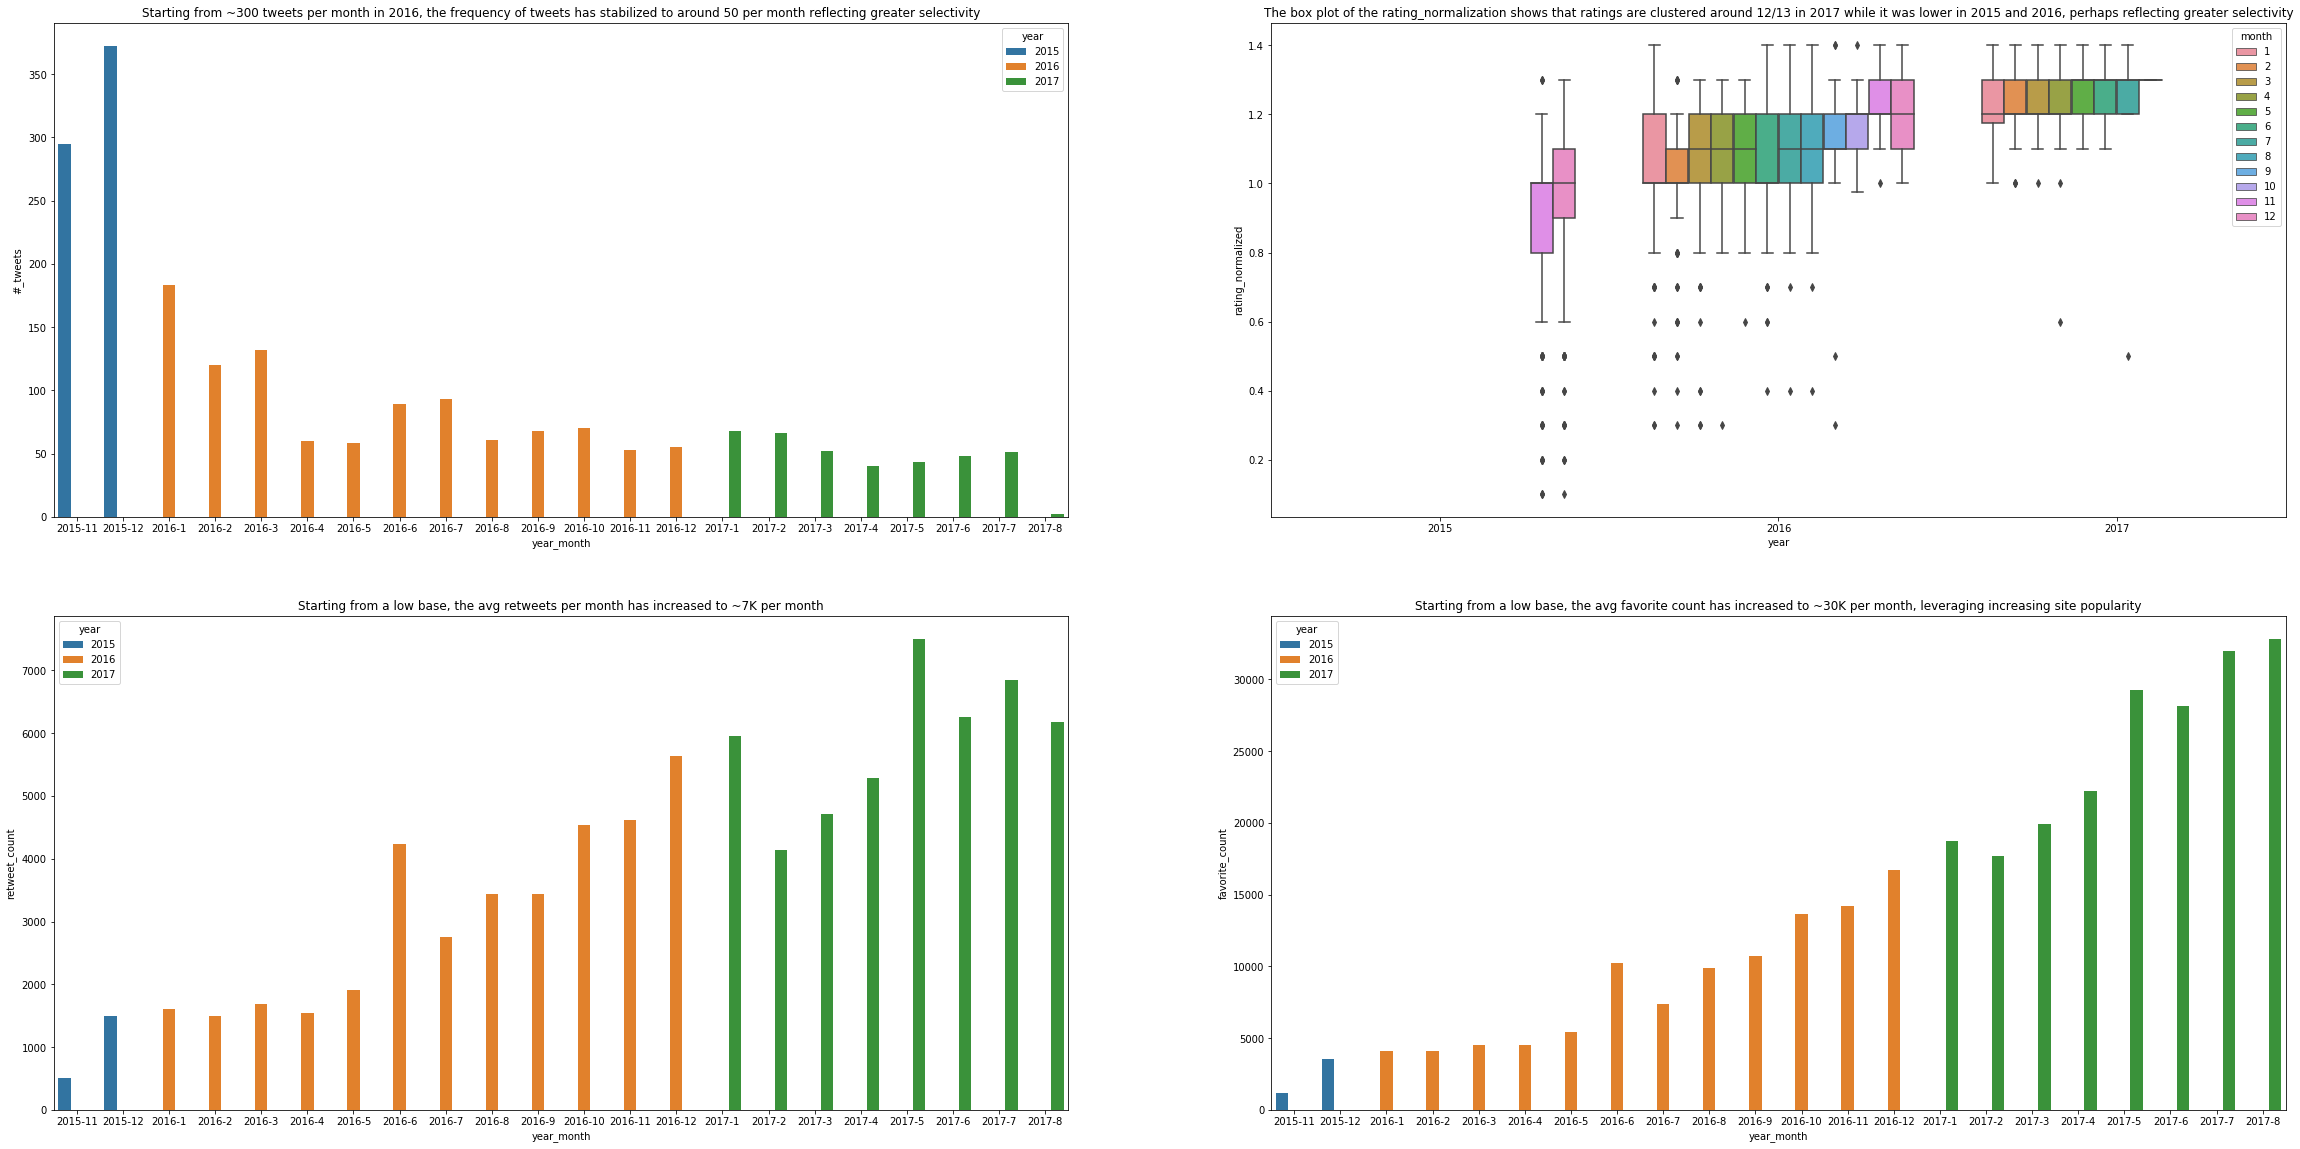

In [488]:
# Plot a few histograms

fig1 = plt.figure(figsize=(40,20))
gs1 = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs1[0, 0])
ax1 = sns.barplot(data=df_tweet_freq,x='year_month',y='#_tweets',hue='year');
ax1.set_title('Starting from ~300 tweets per month in 2016, the frequency of tweets has stabilized to around 50 per month reflecting greater selectivity')

ax2 = plt.subplot(gs1[0, 1])
ax2 = sns.boxplot(data = df_tweet_master_archive, x = 'year',y='rating_normalized',hue='month');
ax2.set_title('The box plot of the rating_normalization shows that ratings are clustered around 12/13 in 2017 while it was lower in 2015 and 2016, perhaps reflecting greater selectivity')

ax3 = plt.subplot(gs1[1, 0])
ax3 = sns.barplot(data=df_tweet_stats,x='year_month',y='retweet_count',hue='year');
ax3.set_title('Starting from a low base, the avg retweets per month has increased to ~7K per month')

ax4 = plt.subplot(gs1[1, 1])
ax4 = sns.barplot(data=df_tweet_stats,x='year_month',y='favorite_count',hue='year');
ax4.set_title('Starting from a low base, the avg favorite count has increased to ~30K per month, leveraging increasing site popularity')

In [489]:
fig1.savefig('plot.jpg')